<a href="https://colab.research.google.com/github/An-Dongsun/Section2-Project/blob/main/AI_13_%EC%95%88%EB%8F%99%EC%84%A0_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HeartDisease 예측모델 Project

# 🎯 해결하고자 하는 문제
## 🎯 Main : 새로운 환자의 설문조사 결과를 바탕으로 심장병의 유무를 파악한다. 

### 🎯 Sub :  심장병에 악영향을 미치는 요인과 심장병을 예방하는 요인을 파악 하고싶다.



# 선정 이유
* 한국인의 사망 원인 1위인 암에 이어 2위인 심장병은 (2010정도 까지 사망원인 2위 였던 뇌혈관질환은 감소한 반면) 지속적으로 상승하고 있어서 위험하다고 판단이 되고 있고 미국에서도 대부분의 인종의 주요 사망 원인 중 하나이다.(모든 사람에게 위험한 질환이다.)

* 3대 사인(암, 심장 질환, 폐렴)은 2020년 기준 전체 사인의 44.9%를 차지하고 있다. → 순환 계통 질환의 사망률 전년 대비 3.2% 증가

* 심장병의 유무를 판단해서 조기에 발견한다면 적절한 관리를 통해 사망확률이 낮아질 수 있는 질병이다.

* 따라서 심장병을 조기에 발견하고 악영향을 미치는 요인을 감지하고 예방하는 것은 의료에서 매우 중요하다.

##심장병의 유무 파악
* 분류문제 → 여러가지 모델을 만들고 성능을 비교해 볼 것이다.  
  * 결정트리 모델
  * 랜덤포레스트 모델
  * XGBoost 모델
  * LightGBM 모델  

* 성능평가 지표
  * f1_beta_score  
    * 정밀도(Precision) VS 재현율(Recall)
    * 심장병이 아니라고 예측했는데 실제로 심장병인 경우 → 치명적이다!   
    * 심장병이라고 예측했는데 실제로는 심장병이 아닌 경우 → 추가 검사를 통해 정정하면 된다.   
    * 따라서 심장병의 유무를 판별하는 모델은 정밀도보다 **재현율(Recall)**이 높아야 한다!

  * logloss 
    * 모델이 얼마나 확신을 가지고 분류를 했는지 파악할 수 있는 지표이다.
    * 숫자가 작아질수록 확신을 가지고 분류를 했다는 점을 알 수 있다.

###심장병에 악영향을 미치는 요인과 심장병을 예방하는 요인 파악
* 모델에 대한 설명 (XAI) → 모델이 결과를 예측할 때 각 특성이 미치는 영향을 파악하고 설명한다.
  * 특성중요도(Mean decrease impurity, MDI)
  * 순열중요도(Permutation Importance, Mean Decrease Accuracy,MDA)
  * PDP(Partial Dependence Plots)
  * SHAP 라이브러리

# 필요한 라이브러리 설치 및 불러오기
* 설치한 후 런타임 초기화 한번 해주어야 한다.   
   
* 런타임 재시작 할때마다 실행되는 것을 방지하기 위해서 주석처리를 했다.
* 코드를 전부 선택한 후 (ctrl + /)를 눌러서 주석처리를 해제하면 코드가 실행된다.

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install markupsafe == 2.0.1
    !pip install --upgrade pandas-profiling
    !pip install pdpbox
    !pip install shap
    !pip install plotly
    !pip install cufflinks
    !pip install pyyaml==5.4.1
    !pip install -U imbalanced-learn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost
import eli5
import shap

import warnings

from markupsafe import escape
from pandas_profiling import ProfileReport

from ipywidgets import interact, fixed

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, log_loss

from sklearn.inspection import permutation_importance

from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

from imblearn.over_sampling  import *

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# 1. 데이터셋 불러오기

In [2]:
#깃허브에 저장되어 있는 데이터 파일을 불러온다.
heart = pd.read_csv('https://raw.githubusercontent.com/An-Dongsun/Section2-Project/main/heart_2020_cleaned.csv')

#전부 잘 불러와졌는지 확인한다.
heart.shape

(319795, 18)

In [3]:
#맨 위 5행을 불러와서 확인한다.
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
#결측치의 갯수를 확인한다.
pd.DataFrame(heart.isnull().sum(), columns=["결측치 개수"])

,결측치 개수
HeartDisease,0
BMI,0
Smoking,0
AlcoholDrinking,0
Stroke,0
PhysicalHealth,0
MentalHealth,0
DiffWalking,0
Sex,0
AgeCategory,0


# 2. feature 설명
* HeartDisease: 관상 동맥 심장 질환(CHD) 또는 심근 경색증(MI)이 있다고 보고한 적이 있는 응답자 (Y/N) <- target
* BMI: 체질량 지수(BMI)
* Smoking: 당신은 일생 동안 적어도 100개비의 담배를 피웠습니까? (Y/N) [참고: 5갑 = 100개비]
* AlcoholDrinking: 과음자(성인 남성은 주당 14잔 이상, 성인 여성은 주당 7잔 이상 음주) (Y/N)
* Stroke: (당신은) 뇌졸중이 있습니까? (Y/N)
* PhysicalHealth: 귀하의 신체적 질병과 부상을 포함한 신체적 건강을 생각해보면, 지난 30일 동안 귀하의 건강이 좋지 않았던 날은 며칠입니까? (0-30일)
* MentalHealth: 귀하의 정신건강을 생각해보면, 지난 30일 동안 귀하의 정신건강이 좋지 않은 날은 며칠입니까? (0-30일)
* DiffWalking: 걷거나 계단을 오르는데 심각한 어려움이 있습니까? (Y/N)
* Sex: 성별 ('Female', 'Male')
* AgeCategory: 연령범주 ('18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older')
* Race: 인종 ('White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Hispanic', 'Other')
* Diabetic: (당신은) 당뇨병이 있습니까? ('Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)')
* PhysicalActivity: 지난 30일 동안 정규직 이외의 신체활동이나 운동을 했다. (Y/N)
* GenHealth: 일반적으로 당신의 건강은 어떤가? ('Excellent', 'Very good', 'Good', 'Fair', 'Poor')
* SleepTime : 귀하는 24시간 중 평균 몇 시간의 수면을 취하십니까? (1 ~ 24)
* Asthma: (당신은) 천식이 있습니까? (Y/N)
* KidneyDisease: 신장 결석, 방광 감염 또는 요실금을 제외하고 신장 질환이 있다는 말을 들은 적이 있습니까? (Y/N)
* SkinCancer: (당신은) 피부암이 있습니까? (Y/N)

In [ ]:
# 각 feature의 고유한 값의 갯수를 구한다.
heart.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

In [ ]:
# 각 feature의 설문 답변을 구하는 코드이다.
heart['Diabetic'].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

# 3. 전처리 & 탐색적 데이터 분석(EDA)

##3-1) 데이터의 타입 파악 및 전처리

###3-1-1) 판다스 프로파일링
* 런타임 재시작 할때마다 실행되는 것을 방지하기 위해서 주석처리를 했다.
* 코드를 전부 선택한 후 (ctrl + /)를 눌러서 주석처리를 해제하면 코드가 실행된다.

In [5]:
# # 판다스 프로파일링 결과 리포트를 pr에 저장
# pr = heart.profile_report()

In [6]:
# # pr에 저장했던 리포트를 출력한다.
# pr 

###3-1-2) 데이터 타입 파악

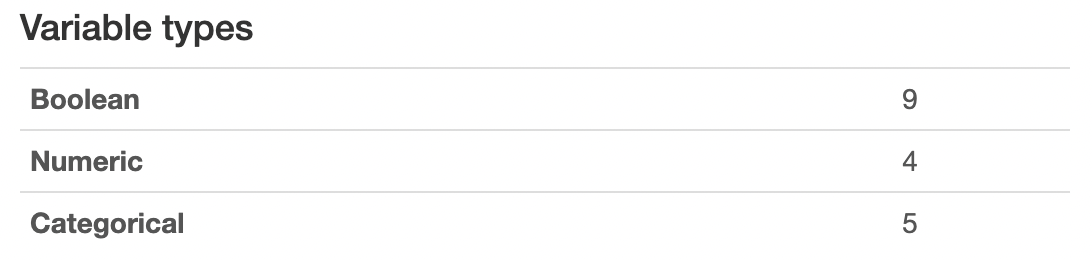

* 데이터 타입   
  * Boolean : HeartDisease, Smoking, AlcoholDrinking, Stroke, DiffWalking, PhysicalActivity, Asthma, KidneyDisease, SkinCancer   
  * Real number : BMI, PhysicalHealth, MentalHealth, SleepTime   
  * Categorical : Sex, AgeCategory, Race, Diabetic, GenHealth   

* Boolean타입 feature는 (Yes → 1, No → 0)로 변환한 후 모델에 넣어야 한다.   
* Categorical타입 데이터는 OrdinalEncoder 또는 TargetEncoder를 이용해서 처리해 준 후 모델에 넣을 것이다.


In [7]:
# Yes = 1, No = 0으로 치환해준다.
BooleanFeature = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

for i in BooleanFeature:
  heart[i] = np.where(heart[i] == 'Yes', 1, 0)

In [8]:
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,Yes,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,No,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,Yes,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,No,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,No,1,Very good,8.0,0,0,0


###3-1-3) 중복행 파악 및 제거

중복된 행이 있으면 데이터 누수 현상이 일어나기 때문에 제거해주는 과정을 거쳐야 한다.

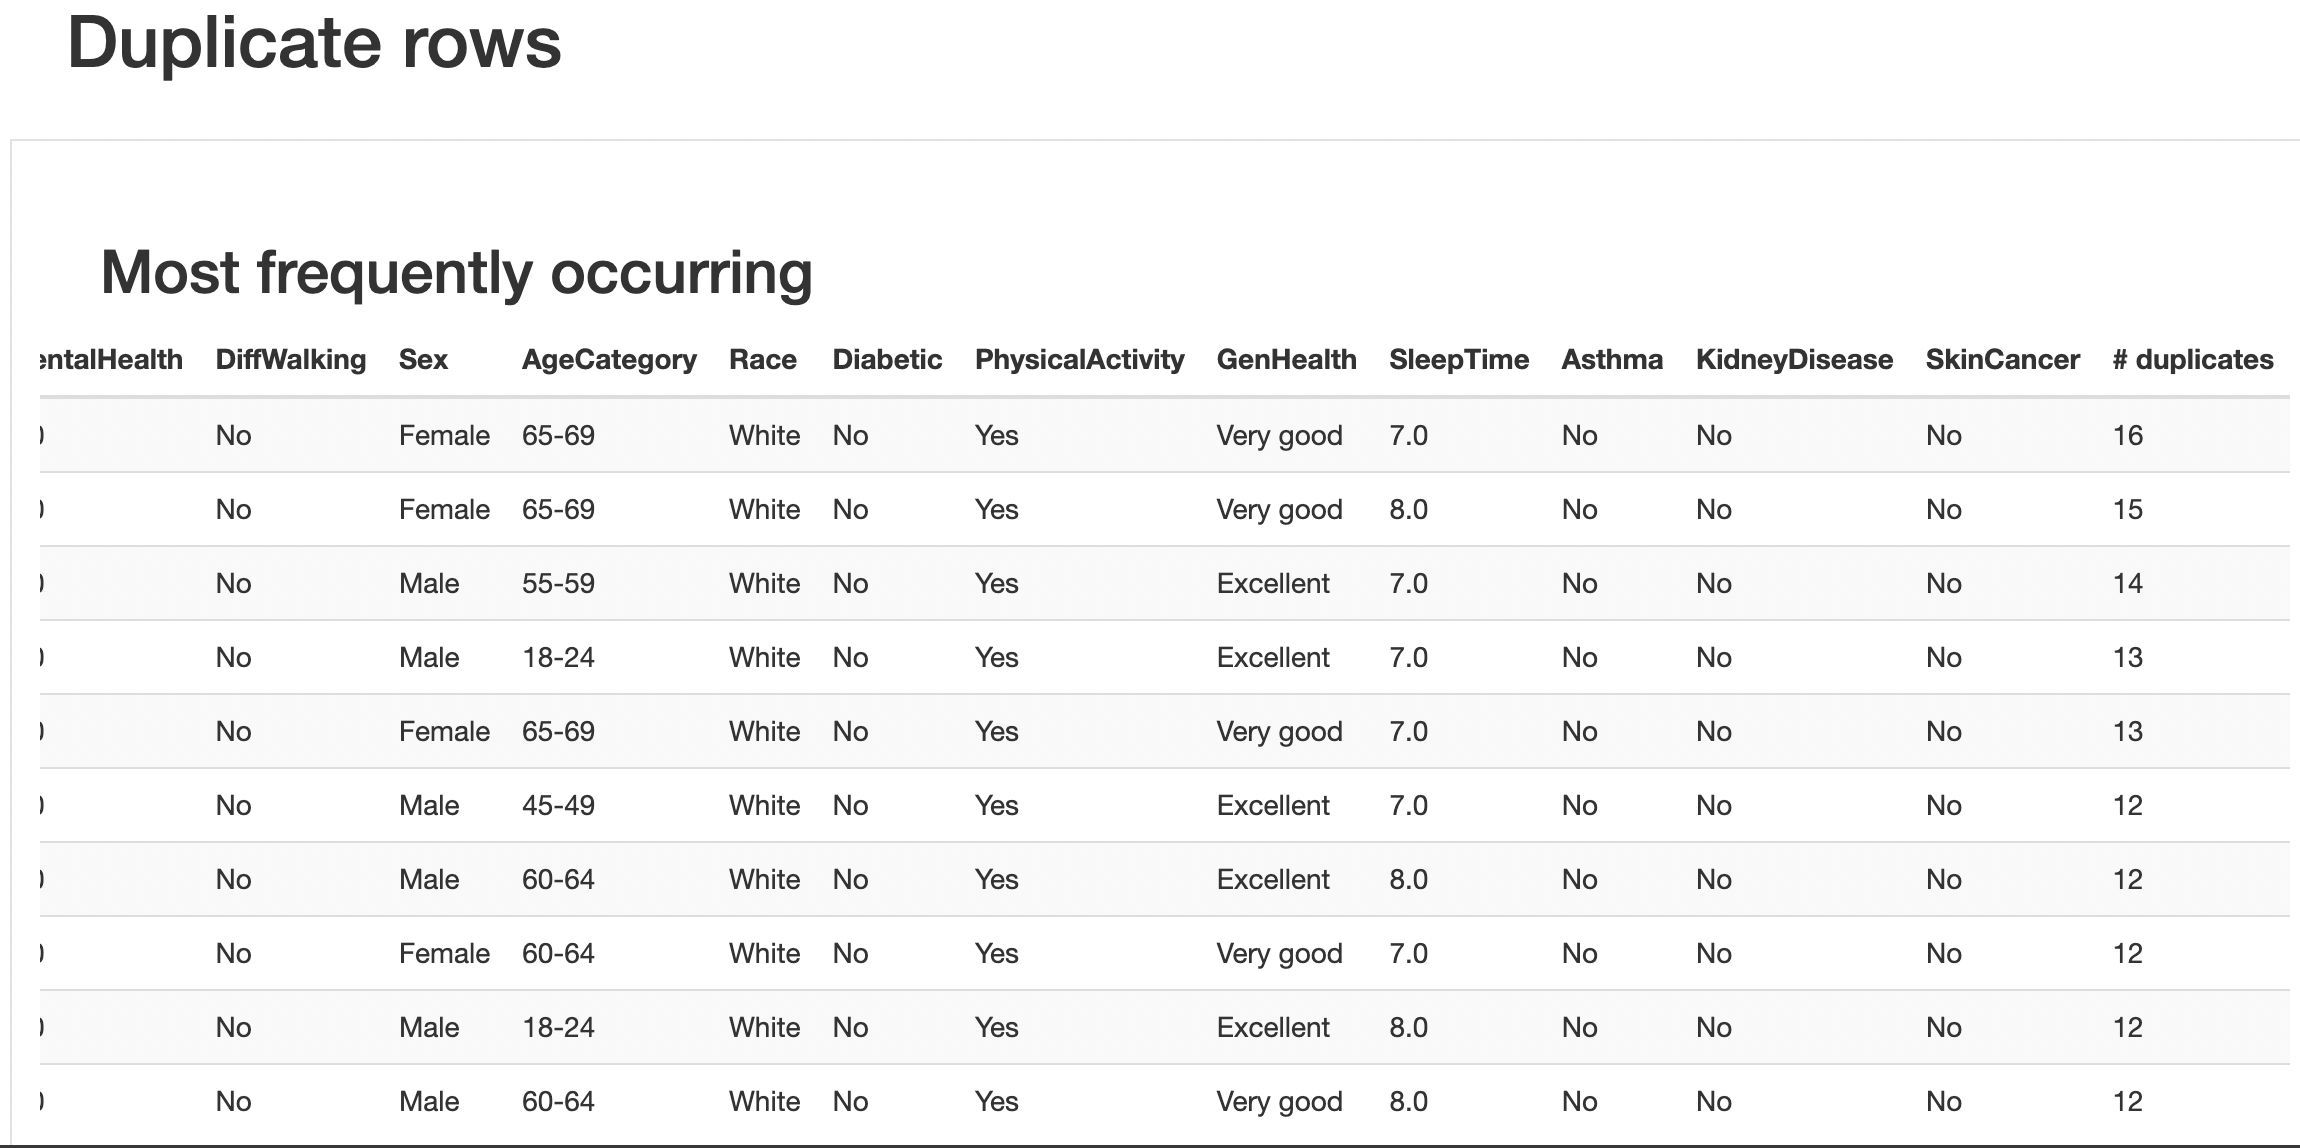

In [9]:
#중복된 행의 갯수를 파악한다.
heart.duplicated().sum()

18078

In [10]:
#중복행 제거(모든 feature가 동일한 경우 맨 처음행만 남긴 후 인덱스를 재설정 해주었다.)
heart = heart.copy().drop_duplicates(keep = 'first', ignore_index = True)
heart.shape

(301717, 18)

맨처음 데이터 : (319795, 18)   
중복행 제거 후 : (301717, 18)   
제거된 중복행 : 18,078행 → 여러번 검사받은 사람들의 맨처음 답변 외 제거된 행의 갯수

In [11]:
#마지막으로 중복된 행이 있는지 파악한다.
heart.duplicated().sum()

0

##3-2) 타겟의 분포 분석

In [12]:
#타겟의 갯수를 확인한다.
heart['HeartDisease'].value_counts()

0    274456
1     27261
Name: HeartDisease, dtype: int64

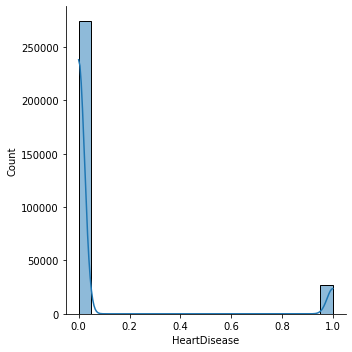

In [13]:
#분포를 시각화하여 확인한다.
sns.displot(heart['HeartDisease'], kde = True);

In [14]:
#등급의 비율을 확인한다.
heart['HeartDisease'].value_counts() / heart['HeartDisease'].value_counts().sum()

0    0.909647
1    0.090353
Name: HeartDisease, dtype: float64

##3-3) 각 feature에 이상치가 있는지 파악하고 제거한다.

###3-3-1) numeric 데이터에 대해서 바이올린 플롯을 그려서 이상치가 존재하는지 파악한다.

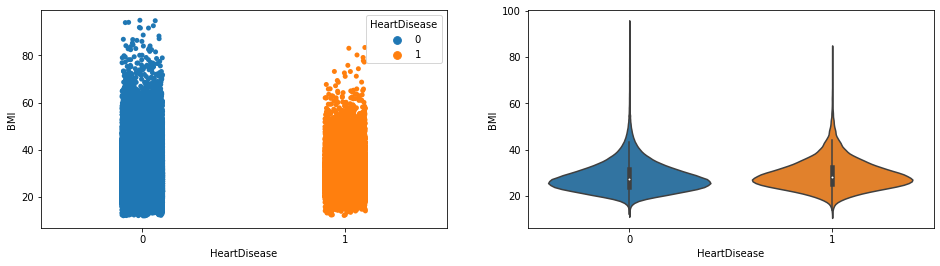

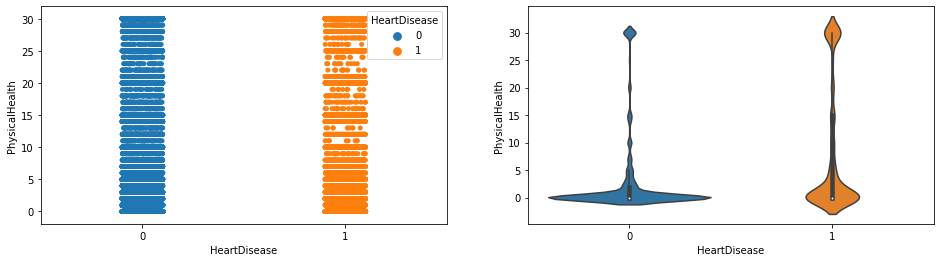

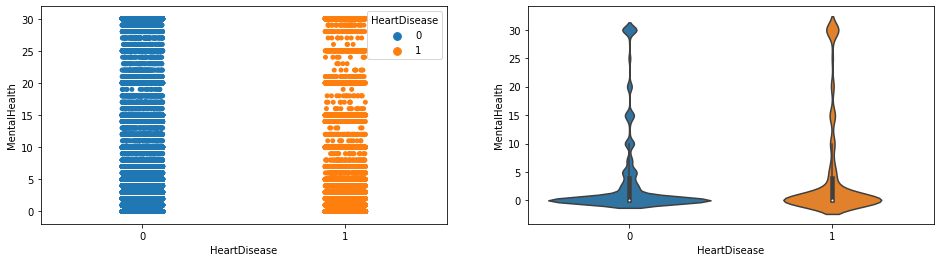

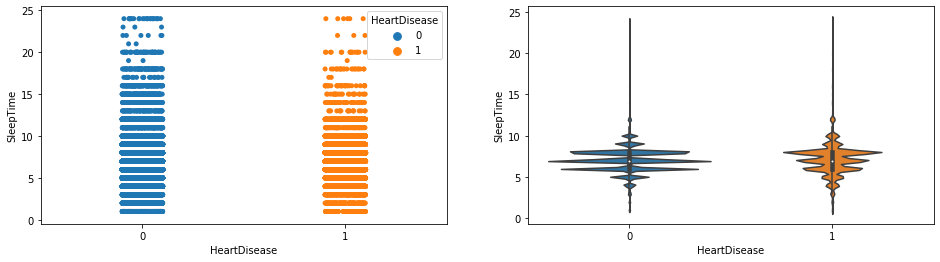

In [15]:
#distribution by 'HeartDisease'

numerical_columns = heart.select_dtypes(exclude=['object','int']).columns.tolist()

def show_dist_plot(df, columns):
    for column in columns:
        f, ax = plt.subplots(1,2,figsize=(16,4))
        sns.stripplot(x=df['HeartDisease'],y=df[column], ax=ax[0],hue=df['HeartDisease'])
        sns.violinplot(data=df, x='HeartDisease', y=column, ax=ax[1])
        
show_dist_plot(heart, numerical_columns)

###3-3-2) BMI와 SleepTime feature에 이상치가 존재한다는 것을 파악했다.

* 이 데이터는 병원에서 진행된 설문조사로 만들어 졌기 때문에 PhysicalHealth, MentalHealth이 건강 한 날이 작은 데이터의 분포가 맞다고 생각하고 따로 제거하지는 않겠다.
* 추후 모델을 만들고 문제가 발생한다면 다시 제거하는 과정을 거치겠다.

[사진 출처 : 삼성 서울병원 홈페이지 건강정보](http://www.samsunghospital.com/home/healthInfo/content/contenView.do?CONT_CLS_CD=001021005001&CONT_ID=3570&CONT_SRC=HOMEPAGE&CONT_SRC_ID=27845)

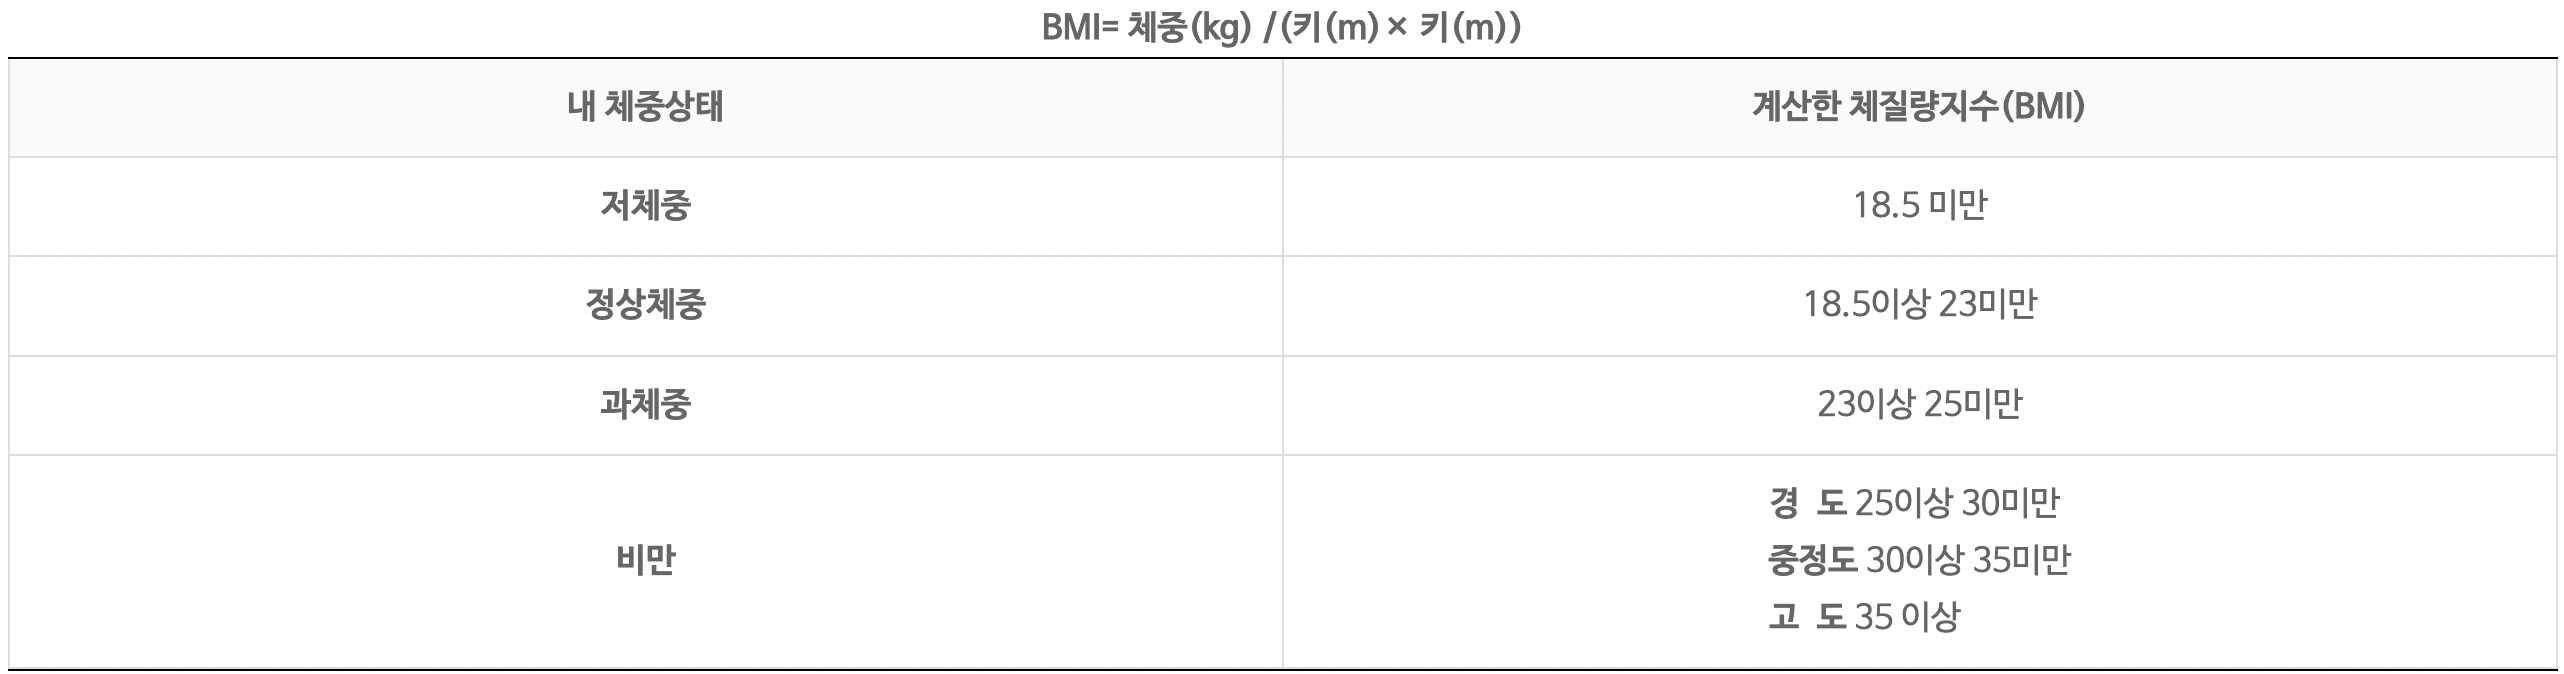

[사진의 출처 : 연합뉴스 기사](https://www.yna.co.kr/view/AKR20220129020800002)

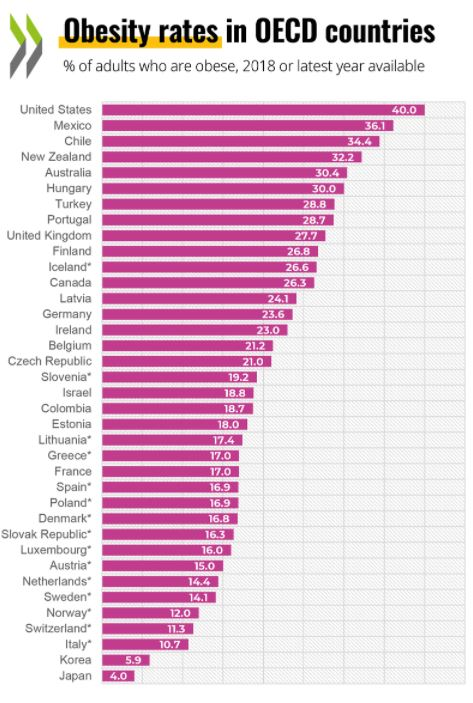

* BMI : 미국의 자료이기 때문에 초고도 비만의 BMI지수일 수 있기 때문에 상위 99.5% 이상의 값만 제거한 후 다시 시각화 하여 이상치의 유무를 확인하겟다.
* SleepTime : 사람이 24시간을 잘수는 없기 때문에 상위 99.5%값을 제거한 후 다시 시각화를 해서 이상치가 있는지 확인한다.

In [16]:
#이상치를 제거한다.
heart['BMI'] = heart.copy()[(heart['BMI'] < np.percentile(heart['BMI'], 99.5))]['BMI']
heart['SleepTime'] = heart.copy()[(heart['SleepTime'] < np.percentile(heart['SleepTime'], 99.5))]['SleepTime']

In [17]:
#위에서 이상치를 제거한 행을 파악한다.
pd.DataFrame(heart.isnull().sum(), columns=["결측치 개수"])

,결측치 개수
HeartDisease,0
BMI,1509
Smoking,0
AlcoholDrinking,0
Stroke,0
PhysicalHealth,0
MentalHealth,0
DiffWalking,0
Sex,0
AgeCategory,0


In [18]:
heart[heart['HeartDisease'] == 1].isnull().sum()

HeartDisease          0
BMI                 170
Smoking               0
AlcoholDrinking       0
Stroke                0
PhysicalHealth        0
MentalHealth          0
DiffWalking           0
Sex                   0
AgeCategory           0
Race                  0
Diabetic              0
PhysicalActivity      0
GenHealth             0
SleepTime           584
Asthma                0
KidneyDisease         0
SkinCancer            0
dtype: int64

In [19]:
heart[heart['HeartDisease'] == 1].count()

HeartDisease        27261
BMI                 27091
Smoking             27261
AlcoholDrinking     27261
Stroke              27261
PhysicalHealth      27261
MentalHealth        27261
DiffWalking         27261
Sex                 27261
AgeCategory         27261
Race                27261
Diabetic            27261
PhysicalActivity    27261
GenHealth           27261
SleepTime           26677
Asthma              27261
KidneyDisease       27261
SkinCancer          27261
dtype: int64

In [20]:
#일단 데이터가 많아서 이상치가 제거되어 결측치가 발생한 행은 제거해준다.
heart = heart.dropna().reset_index(drop = True)
heart.shape

(297047, 18)

###3-3-3) numeric 데이터에 대해서 바이올린 플롯을 그려서 이상치가 잘 제거되었는지 확인한다.

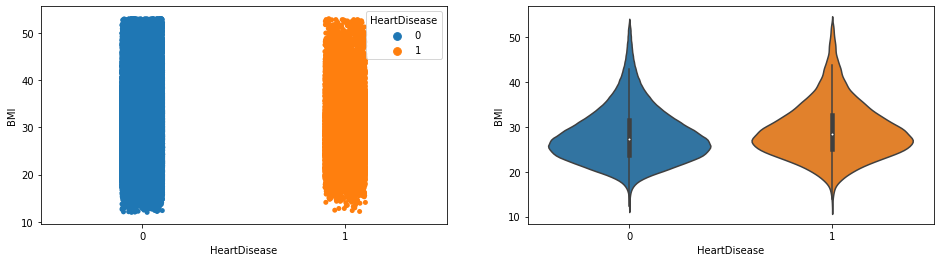

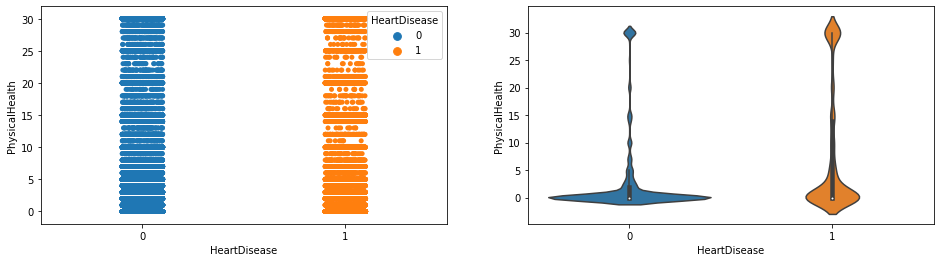

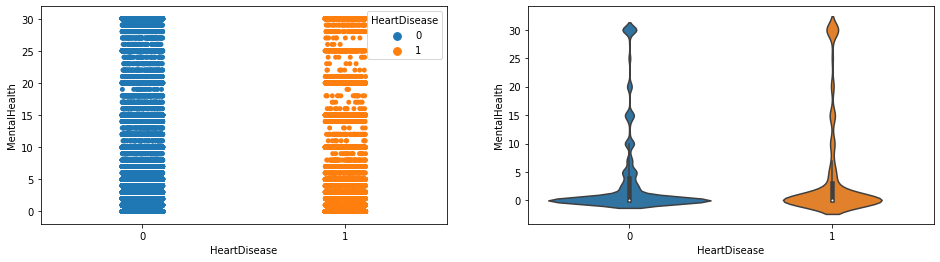

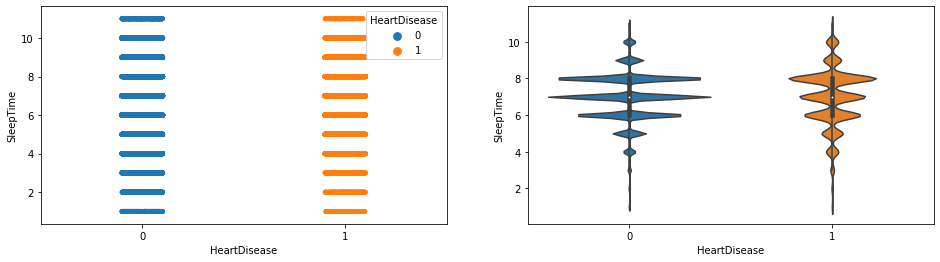

In [21]:
#distribution by 'HeartDisease'

numerical_columns = heart.select_dtypes(exclude=['object','int']).columns.tolist()

def show_dist_plot(df, columns):
    for column in columns:
        f, ax = plt.subplots(1,2,figsize=(16,4))
        sns.stripplot(x=df['HeartDisease'],y=df[column], ax=ax[0],hue=df['HeartDisease'])
        sns.violinplot(data=df, x='HeartDisease', y=column, ax=ax[1])
        
show_dist_plot(heart, numerical_columns)

모델을 만들고 과하게 제거되어 문제가 발생한다면 이상치 제거 기준을 조정해 주겠다.

##3-4) 타겟의 분포 재분석

In [22]:
#타겟의 갯수를 확인한다.
heart['HeartDisease'].value_counts()

0    270528
1     26519
Name: HeartDisease, dtype: int64

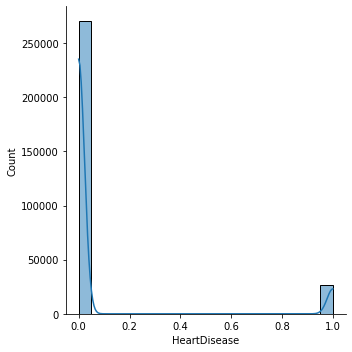

In [23]:
#분포를 시각화하여 확인한다.
sns.displot(heart['HeartDisease'], kde = True);

In [24]:
#등급의 비율을 확인한다.
heart['HeartDisease'].value_counts() / heart['HeartDisease'].value_counts().sum()

0    0.910725
1    0.089275
Name: HeartDisease, dtype: float64

##3-5) 타겟값에 따른 feature 분석

###3-5-1) HeartDisease = 1 (심장병이 있는 경우)

In [25]:
heart[heart['HeartDisease'] == 1].describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
count,26519.0,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000,26519.000000
mean,1.0,29.219759,0.585618,0.041404,0.158000,7.655756,4.534296,0.359478,0.644481,7.006109,0.178476,0.124514,0.183604
std,0.0,6.136752,0.492624,0.199227,0.364748,11.396207,9.062292,0.479857,0.478679,1.520221,0.382920,0.330174,0.387168
min,1.0,12.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.0,25.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,1.0,28.320000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000
75%,1.0,32.550000,1.000000,0.000000,0.000000,14.000000,3.000000,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000
max,1.0,52.960000,1.000000,1.000000,1.000000,30.000000,30.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000


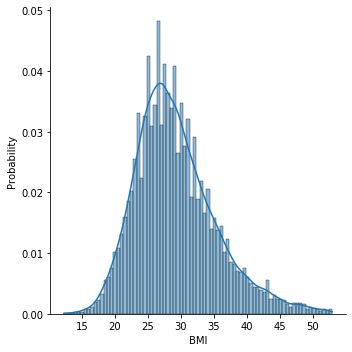

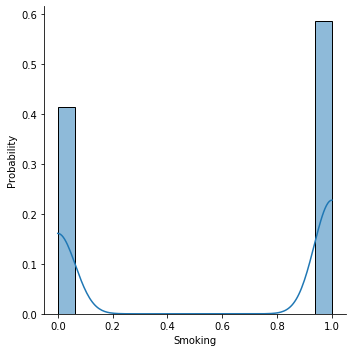

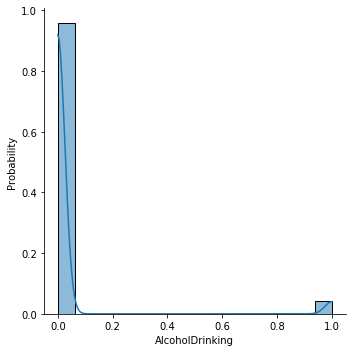

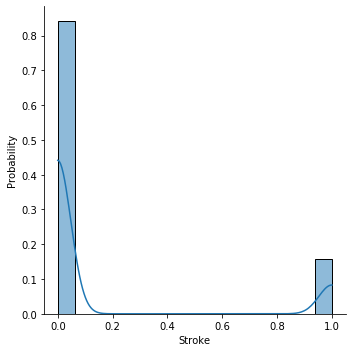

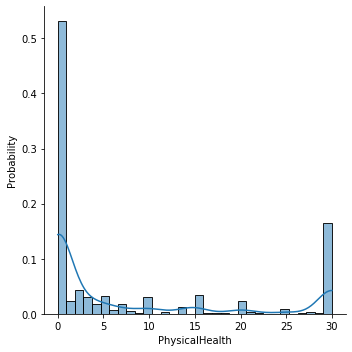

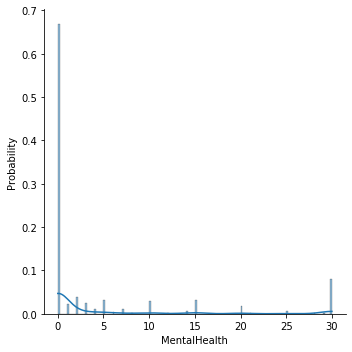

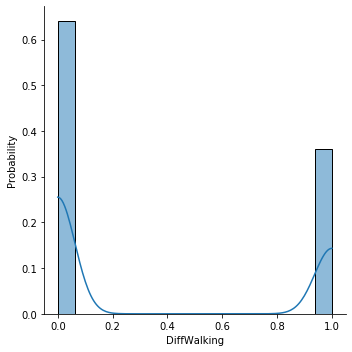

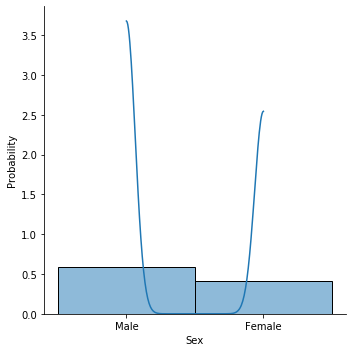

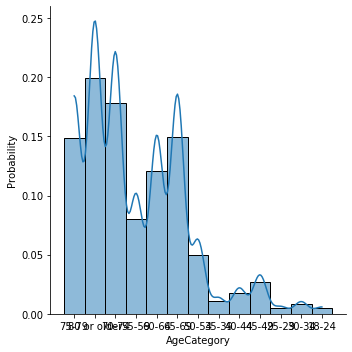

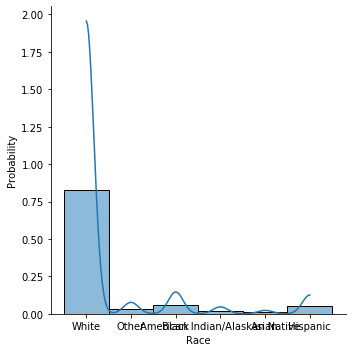

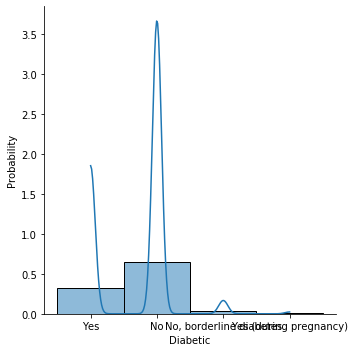

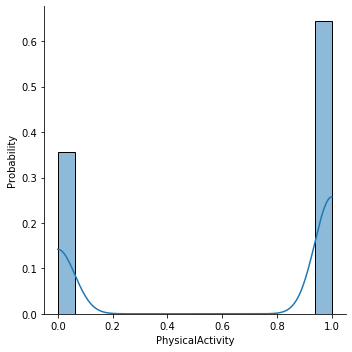

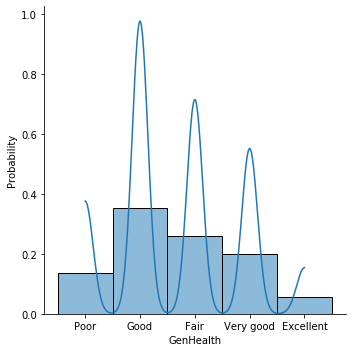

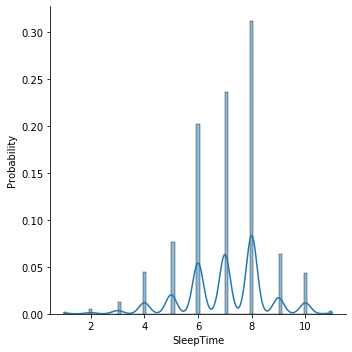

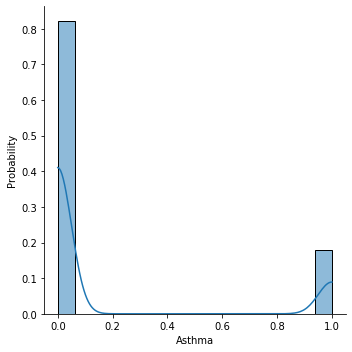

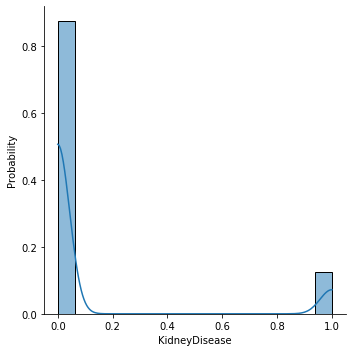

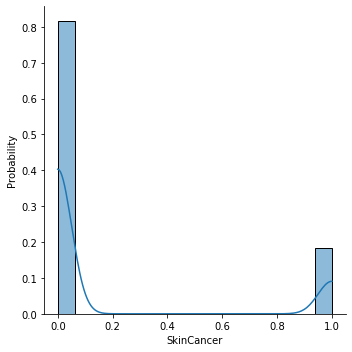

In [26]:
#심장병이 있는 경우 feature의 분포를 시각화하여 확인한다.
columns = heart.columns
columns = columns.copy().drop('HeartDisease')

for i in columns :
  sns.displot(heart[heart['HeartDisease'] == 1][i], kde = True, stat = "probability");

###3-5-2) HeartDisease = 0 (심장병이 없는 경우)

In [27]:
heart[heart['HeartDisease'] == 0].describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
count,270528.0,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000,270528.000000
mean,0.0,28.183445,0.405171,0.074769,0.027554,3.073065,4.018009,0.121152,0.779897,7.022349,0.136374,0.029819,0.088915
std,0.0,6.054681,0.490926,0.263018,0.163690,7.494172,7.951800,0.326304,0.414317,1.285630,0.343186,0.170089,0.284622
min,0.0,12.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.0,23.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,0.0,27.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000
75%,0.0,31.460000,1.000000,0.000000,0.000000,2.000000,4.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
max,0.0,53.000000,1.000000,1.000000,1.000000,30.000000,30.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000


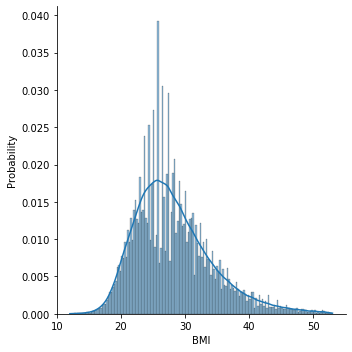

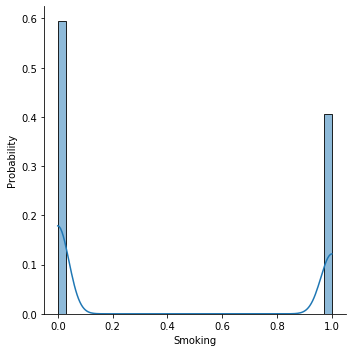

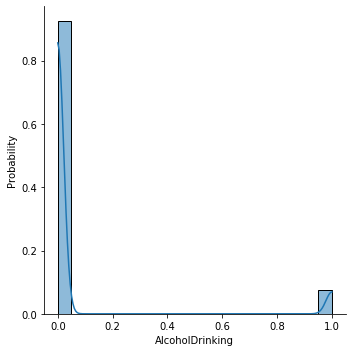

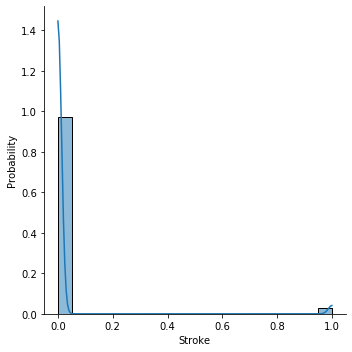

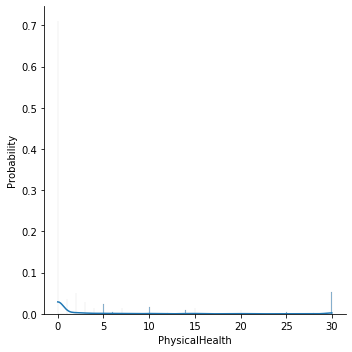

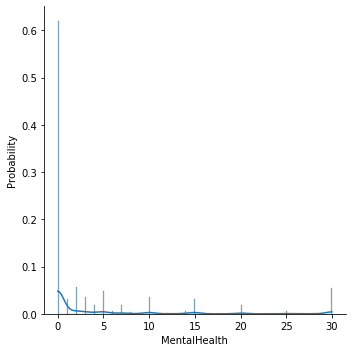

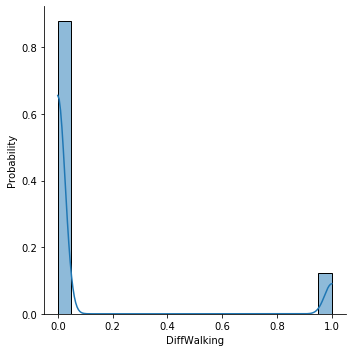

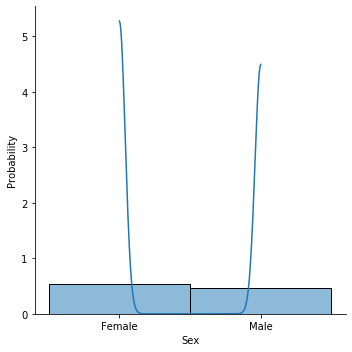

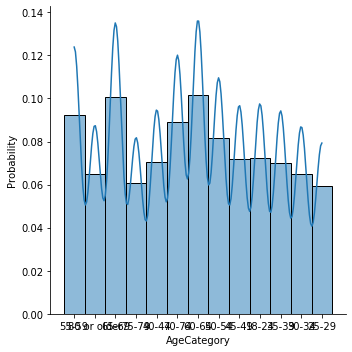

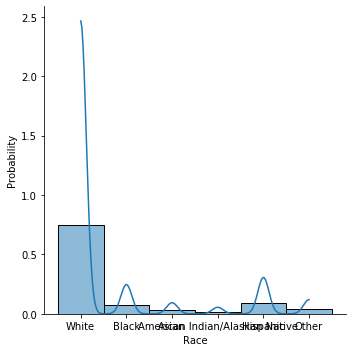

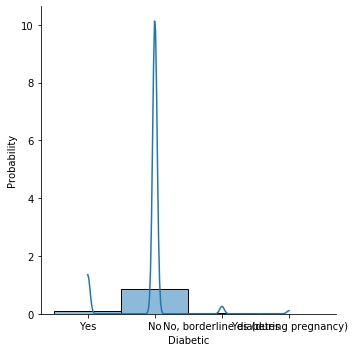

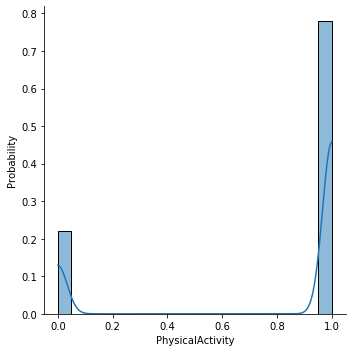

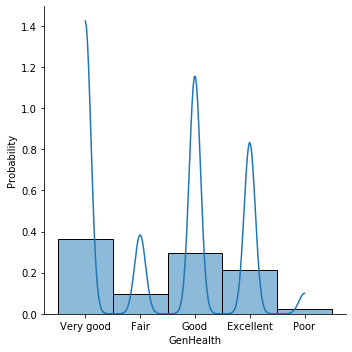

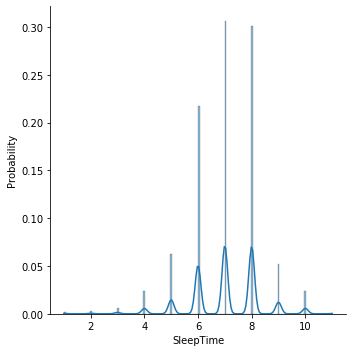

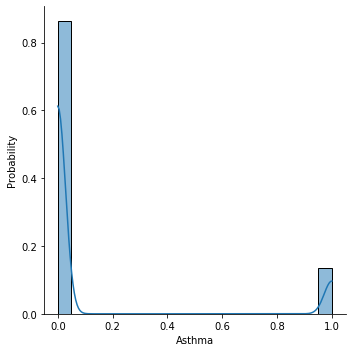

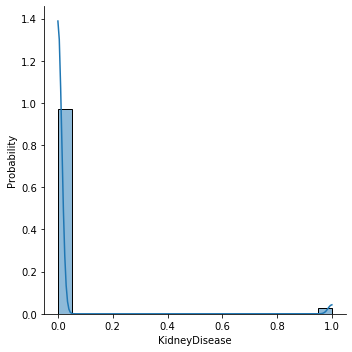

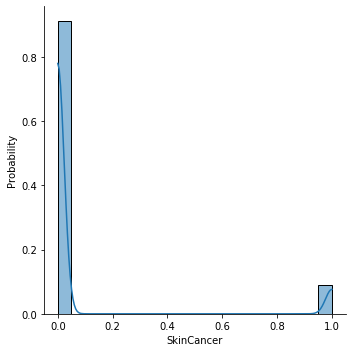

In [28]:
#심장병이 없는 경우 feature의 분포를 시각화하여 확인한다.
for i in columns :
  sns.displot(heart[heart['HeartDisease'] == 0][i], kde = True, stat = "probability");

###3-5-3) 추가 시각화
PhysicalHealth, AgeCategory, Race, Diabetic, GenHealth에 대한 시각화가 식별하기 어렵게 나와서 다시 시각화를 해서 비교하겠다.

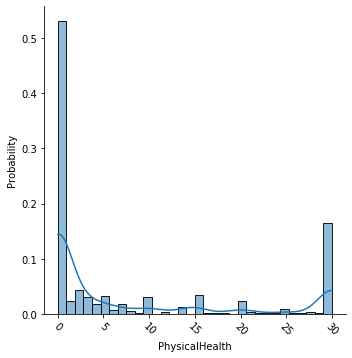

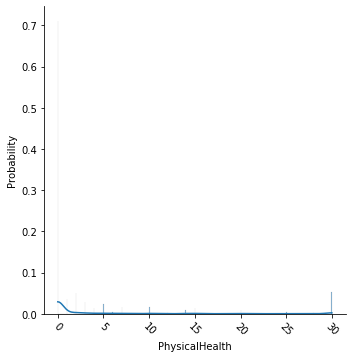

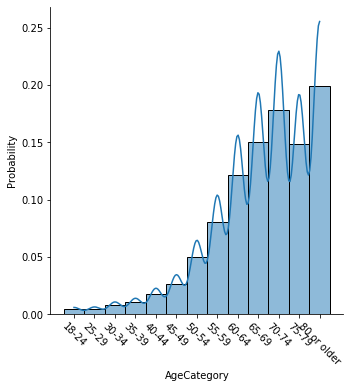

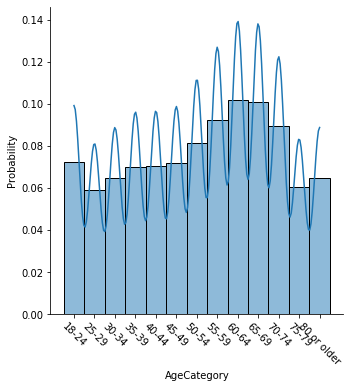

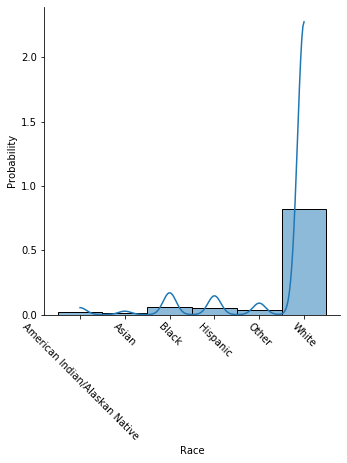

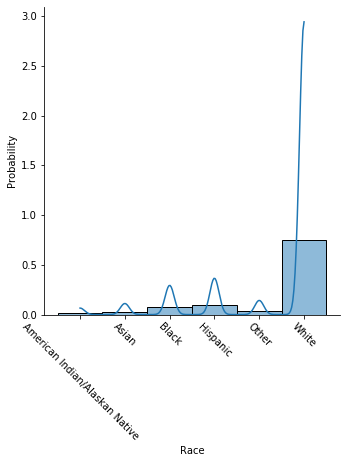

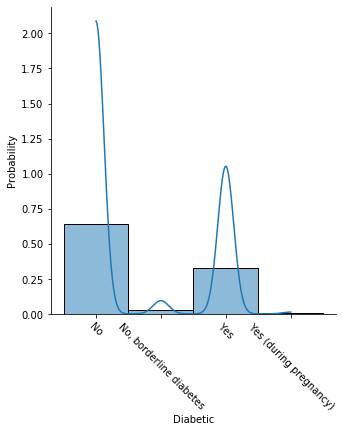

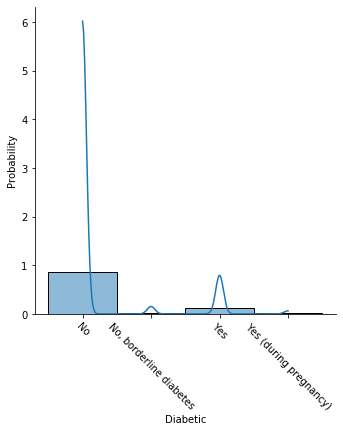

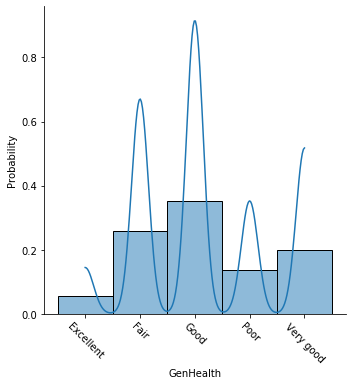

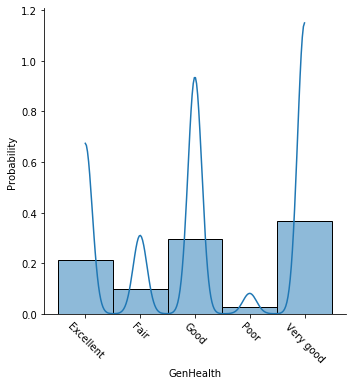

In [29]:
snscolumns = ['PhysicalHealth', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth']

for i in snscolumns :
  sns.displot(heart[heart['HeartDisease'] == 1][i].sort_values(), kde = True, stat = "probability")
  plt.xticks(rotation = - 45 )
  sns.displot(heart[heart['HeartDisease'] == 0][i].sort_values(), kde = True, stat = "probability")
  plt.xticks(rotation = - 45 )

###3-5-4) 나이에 따른 심장병, 신장병, 피부암 확률

No handles with labels found to put in legend.


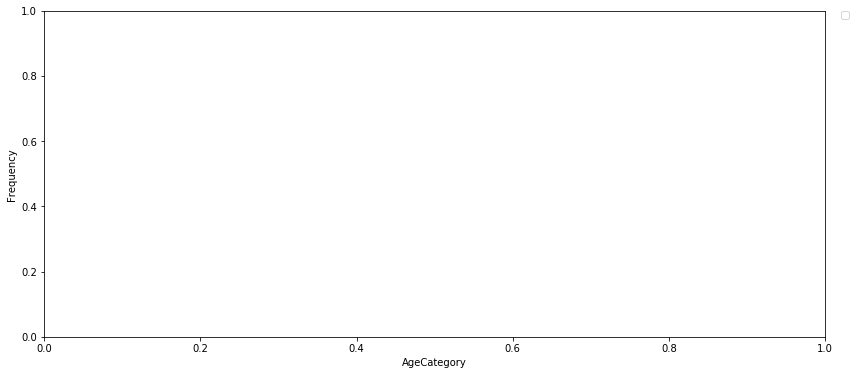

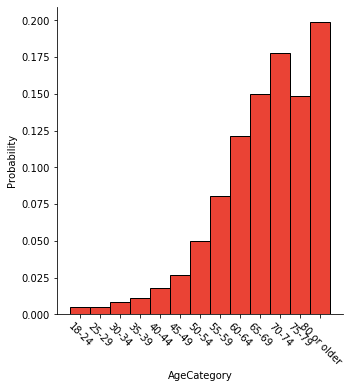

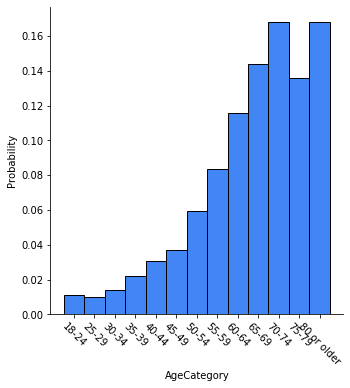

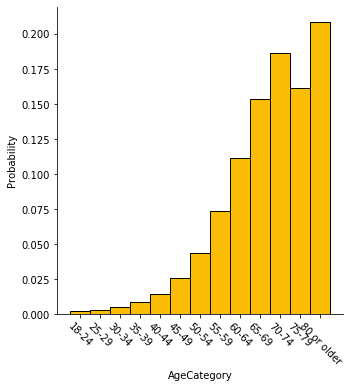

In [30]:
fig, ax = plt.subplots(figsize = (14,6))
#나이에 따른 심장병이 있는 사람의 비율
sns.displot(heart[heart["HeartDisease"] == 1]["AgeCategory"].sort_values(), alpha=1, color="#ea4335", label="HeartDisease", stat = "probability")
plt.xticks(rotation = - 45 )
#나이에 따른 신장병이 있는 사람의 비율
sns.displot(heart[heart["KidneyDisease"] == 1 ]["AgeCategory"].sort_values(), alpha=1, color="#4285f4", label="KidneyDisease", stat = "probability")
plt.xticks(rotation = - 45 )
#나이에 따른 피부암이 있는 사람의 비율
sns.displot(heart[heart["SkinCancer"] == 1 ]["AgeCategory"].sort_values(), alpha=1, color="#fbbc05", label="SkinCancer", stat = "probability")
plt.xticks(rotation = - 45 )

ax.set_xlabel("AgeCategory")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

###3-5-5) 성별에 따른 심장병 확률

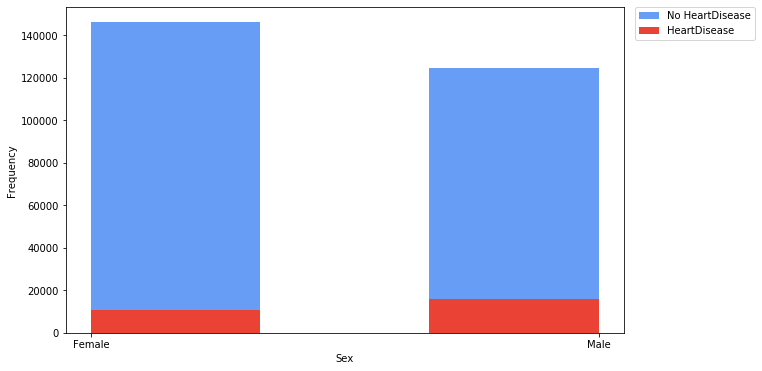

In [31]:
fig, ax = plt.subplots(figsize = (10,6))

ax.hist(heart[heart["HeartDisease"] == 0]["Sex"], bins=3, alpha=0.8, color="#4285f4", label="No HeartDisease")
ax.hist(heart[heart["HeartDisease"] == 1]["Sex"], bins=3, alpha=1, color="#ea4335", label="HeartDisease")

ax.set_xlabel("Sex")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

In [32]:
#성별에 따른 심장병이 있는 비율 계산
female_with_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['Sex'] == 'Female')])
num_female = len(heart[heart['Sex'] == 'Female'])
male_with_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['Sex'] == 'Male')])
num_male = len(heart[heart['Sex'] == 'Male'])
print('Probability of Male to have Heart disease:', male_with_heart_disease/num_male)
print('Probability of Female to have Heart disease:', female_with_heart_disease/num_female)

Probability of Male to have Heart disease: 0.11187393842508671
Probability of Female to have Heart disease: 0.06909670224629601


###3-5-6) 담배를 100개피 이상 피운 것과 심장병의 상관관계

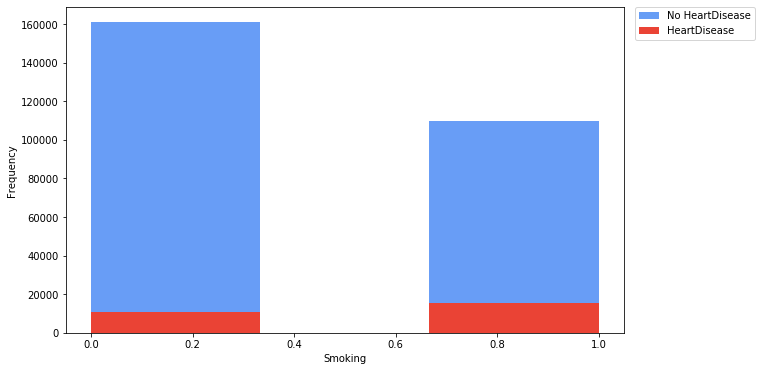

In [33]:
fig, ax = plt.subplots(figsize = (10,6))

ax.hist(heart[heart["HeartDisease"] == 0]["Smoking"], bins=3, alpha=0.8, color="#4285f4", label="No HeartDisease")
ax.hist(heart[heart["HeartDisease"] == 1]["Smoking"], bins=3, alpha=1, color="#ea4335", label="HeartDisease")

ax.set_xlabel("Smoking")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

In [34]:
smoke_and_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['Smoking'] == 1)])
num_smoke = len(heart[heart['Smoking'] == 1])
no_smoke_and_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['Smoking'] == 0)])
num_no_smoke = len(heart[heart['Smoking'] == 0])
print('Probability of Heart disease if you smoke:', smoke_and_heart_disease/num_smoke)
print("Probability of Heart disease if you don't smoke:", no_smoke_and_heart_disease/num_no_smoke)

Probability of Heart disease if you smoke: 0.12410100687230302
Probability of Heart disease if you don't smoke: 0.06392409849511654


###3-5-7) 인종에 따른 심장병 발병 비율

Text(0.5, 1.0, 'Variation of Heart Disease amoung Races')

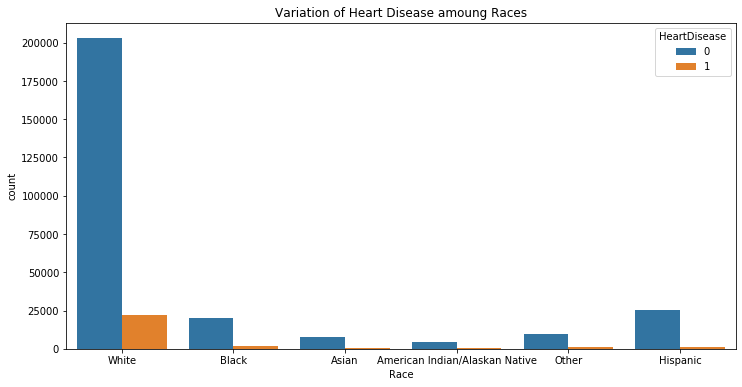

In [35]:
plt.figure(figsize=(12,6))
sns.countplot(heart['Race'], hue = heart['HeartDisease'])
plt.title('Variation of Heart Disease amoung Races')

In [36]:
len(heart[(heart['HeartDisease'] == 1) & (heart['Race'] == 'White')]['Race']) / len(heart[heart['HeartDisease'] == 1]['Race'])

0.8243523511444625

In [37]:
len(heart[(heart['HeartDisease'] == 0) & (heart['Race'] == 'White')]['Race']) / len(heart[heart['HeartDisease'] == 0]['Race'])

0.750221788502484

###3-5-8) 폭음 여부에 다른 심장병 확률

Text(0.5, 1.0, 'Variation of Heart Disease amoung AlcoholDrinking')

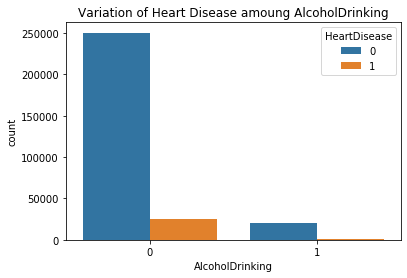

In [38]:
sns.countplot(heart['AlcoholDrinking'], hue = heart['HeartDisease'])
plt.title('Variation of Heart Disease amoung AlcoholDrinking')

In [39]:
AlcoholDrinking_and_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['AlcoholDrinking'] == 1)])
num_drink = len(heart[heart['AlcoholDrinking'] == 1])
no_AlcoholDrinking_and_heart_disease = len(heart[(heart['HeartDisease'] == 1) & (heart['AlcoholDrinking'] == 0)])
num_no_drink = len(heart[heart['AlcoholDrinking'] == 0])
print('Probability of Heart disease if you Drinking Alcohol:', AlcoholDrinking_and_heart_disease/num_drink)
print("Probability of Heart disease if you don't Drinking Alcohol:", no_AlcoholDrinking_and_heart_disease/num_no_drink)

Probability of Heart disease if you Drinking Alcohol: 0.05148886283704572
Probability of Heart disease if you don't Drinking Alcohol: 0.09219793850327504


##3-6) EDA결과 얻은 Insights

* 심장병이 있는 사람들은 담배를 100개피 이상 피운 사람의 비율이 높았다.
* 심장병이 있는 경우 걷는것에 문제가 있는 사람의 비율이 높았다.
* 심장병, 피부암, 신장병 모두 나이가 들수록 걸릴 확률이 높아진다.
* 남성이 여성보다 심장병에 걸릴 확률이 높았다.
* 담배를 100개피 이상 피운 경우 심장병에 걸릴 확률이 2배정도 높았다.
* 폭음을 하는 경우 심장병에 걸릴 확률이 증가하기는 하지만 미미한 수준이다. 

#4. 데이터 랭글링

##4-1) 심장병과 관련이 높다고 생각되는 질병 유무 feature
* DiffWalking  : 심장질환이 있는 경우 혈액의 순환이 잘 안되어 다리나 신체의 말단이 붓고 거동이 불편한 경우가 많다고 한다.
* KidneyDisease: (신장질환)
  * 심장 기능이 저하되면 신장이 정상적으로 혈액을 공급받지 못하면서 신장 기능이 함께 저하된다. 심장 기능이 떨어져 신장에 흐르는 혈액이 제때 나가지 못하면 ‘울혈’이 생기고 내부 압력이 증가할 수 있으며, 심장 질환과 동반된 전신적 염증 반응으로 인해 신장이 손상되기도 한다.
  * 신장 질환 또한 심장 건강을 위협하는 원인이 된다. 신장에 문제가 생기면 혈액 속 노폐물을 제대로 거르지 못하면서 요독증, 고인산혈증 등을 유발할 수 있는데, 이 같은 질환이 심장에 손상을 주기도 한다. 또 적혈구를 만드는 ‘조혈 호르몬’과 같이 신장에서 만들어지는 호르몬이 제대로 분비되지 않는 경우에도 심장에 부담을 준다.
  * 신장병 환자의 경우 조금만 걸어도 가슴이 쥐어오는 느낌을 받고 숨이 차면 심장병을 의심해볼 수 있다.

* Asthma(천식)
  * 천식 환자들은 천식이 없는 환자들보다 심장발작, 뇌졸중 등과 같은 심혈관 위험이 60% 더 높다고 알려져 있다.
  * 천식 증상은 가슴 불편함 또는 가슴 통증과 혼동될 수 있다.

##4-2) feature간의 corr구해보기

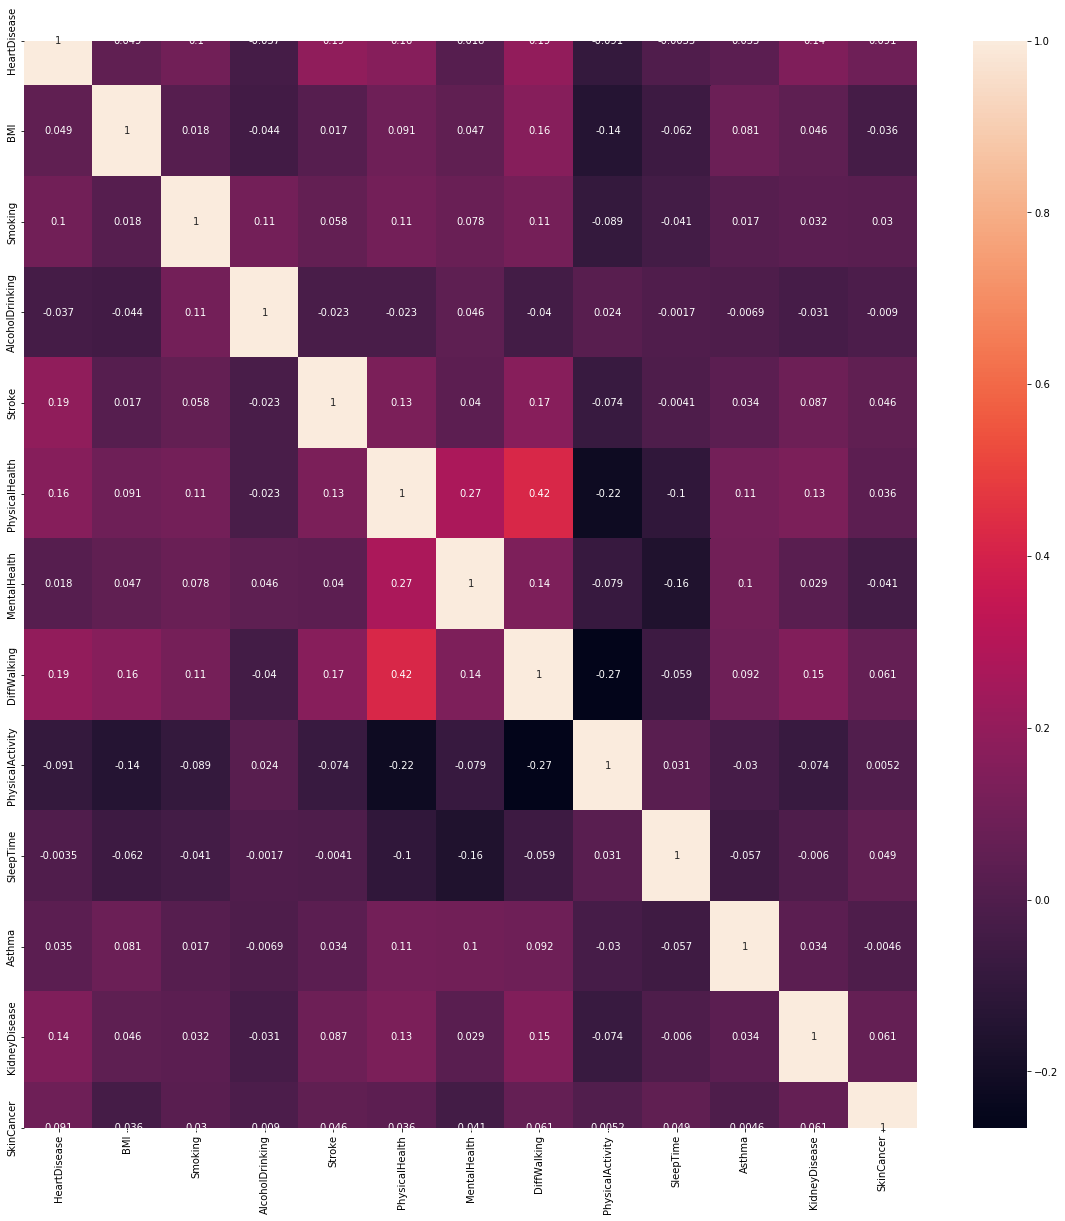

In [ ]:
corr_matrix = heart.corr()
plt.figure(figsize = (20,20))
sns_plot=sns.heatmap(corr_matrix,annot=True)
plt.show()

In [ ]:
#HeartDisease와 corr 값 보기
heart.corr().iloc[:,0].sort_values(ascending = False)

HeartDisease        1.000000
DiffWalking         0.194445
Stroke              0.191662
PhysicalHealth      0.162768
KidneyDisease       0.140738
Smoking             0.104205
SkinCancer          0.091074
BMI                 0.048687
Asthma              0.034584
MentalHealth        0.018268
SleepTime          -0.003540
AlcoholDrinking    -0.036854
PhysicalActivity   -0.091449
Name: HeartDisease, dtype: float64

In [ ]:
# corr값이 0보다 작은 feature들은 제거해준다.
heart = heart.copy().drop(columns = ['SleepTime', 'AlcoholDrinking', 'PhysicalActivity'])

## 4-3) BMI 수치를 카테고리화 해서 나눠준다.

[사진 출처 :](http://www.hanhodaily.com/news/articleView.html?idxno=48226) http://www.hanhodaily.com/news/articleView.html?idxno=48226

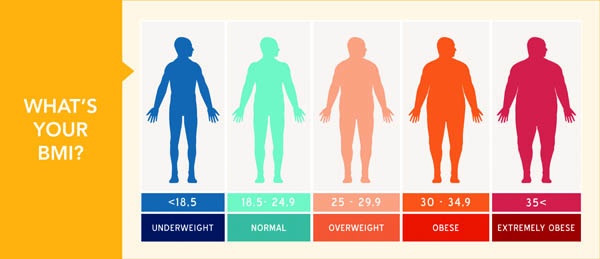

In [40]:
heart['BMI'].max()

53.0

In [41]:
heart['BMI'].min()

12.02

In [42]:
#BMI 수치에 따라서 분류해주는 함수를 작성한다.
def BMI_mask(x):
  if x < 18.5:
    return 1
  elif (18.5 <= x) & (x < 25):
    return 2
  elif (25 <= x) & (x < 30):
    return 3
  elif (30 <= x) & (x < 35):
    return 4
  elif (35 <= x) & (x < 40):
    return 5
  elif (40 <= x) & (x < 45):
    return 6
  elif (45 <= x) & (x < 50):
    return 7
  else :
    return 8

#위의 분류기를 적용해준다.
heart['BMI'] = heart['BMI'].apply(BMI_mask)

In [43]:
heart['BMI'].describe()

count    297047.000000
mean          3.191411
std           1.200836
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           8.000000
Name: BMI, dtype: float64

# 5.기준모델 설정

## 5-1)데이터를 훈련/테스트 세트로 분리
* 따로 테스트 데이터가 주어지지 않았음으로 랜덤하게 데이터를 나누어서 훈련/테스트 세트를 만들어준다.
* stratify는 타겟 데이터의 비율을 유지하면서 분히하기 위해서 사용해 주었다.

In [44]:
#target을 설정해준다.
target = 'HeartDisease'

#데이터를 훈련/테스트 세트로 분리한다.(train/test = 90%/10%의 비율로 나누어 주었다.)
train, test = train_test_split(heart, train_size = 0.90, test_size = 0.10,
                               stratify = heart[target], random_state = 42)

#train데이터를 train/validation으로 무작위로 나누어 준다.(train/validation = 80%/20%)
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20,
                              stratify = train[target], random_state = 42)

train.shape, val.shape, test.shape

((213873, 18), (53469, 18), (29705, 18))

In [45]:
#target과 학습할 feature를 분리해준다.
y_train = train[target]
X_train = train.copy().drop(columns = [target])

y_val = val[target]
X_val = val.copy().drop(columns = [target])

y_test = test[target]
X_test = test.copy().drop(columns = [target])

###5-1-2)모든 예측 결과를 최빈값인 0으로 예상하는 모델을 만든다.

In [46]:
# 타겟 샘플 수 만큼 0이 담긴 리스트를 만든다. (기준모델로 타겟인 HeartDisease의 값을 전부 0으로 찍는 모델이다.)
y_pred = [0] * len(y_train)

# 최다 클래스의 빈도가 정확도가 된다. (소수점 3번째 자리에서 반올림해서 나타냈다.)
print("training accuracy: ", round(accuracy_score(y_train, y_pred), 2))

training accuracy:  0.91


In [47]:
# 타겟 샘플 수 만큼 0이 담긴 리스트를 만든다. (기준모델로 타겟인 HeartDisease의 값을 전부 0으로 찍는 모델이다.)
y_val_pred = [0] * len(y_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     48696
           1       0.00      0.00      0.00      4773

    accuracy                           0.91     53469
   macro avg       0.46      0.50      0.48     53469
weighted avg       0.83      0.91      0.87     53469



* 정확도인 accuracy는 0.91로 높은 반면 target인 1에 대해서는 전혀 예측하지 못하는 모델이다.
* 따라서 분류모델의 성능을 평가하는 지표를 f1-score를 이용해서 정밀도(precision)과 재현율(recall)을 살펴 보아야 한다.

## 5-2) 결정트리 모델을 용해서 분류를 해본다.

In [63]:
# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train)/(2*np.bincount(y_train))
custom

array([0.54901452, 5.60052896])

In [ ]:
#파이프라인을 이용해서 결정 트리 모델을 만들어 준다.
pipe = make_pipeline(
    TargetEncoder(), 
		SimpleImputer(),
    DecisionTreeClassifier(random_state = 42, criterion = 'entropy', class_weight = {False:custom[0], True:custom[1]}, max_depth = 11)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  0.7304755626002347
검증 정확도:  0.7219884419009146


In [ ]:
y_proba = pipe.predict_proba(X_val)
# 사이킷런 결과 확인
sklearn_reslt = log_loss(y_val, y_proba)
print("sklearn_reslt", sklearn_reslt)

sklearn_reslt 0.6341768158165078


###5-2-1) Confusion matrix를 그려본다.

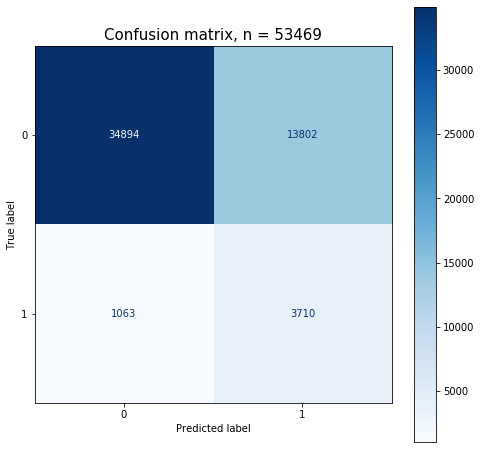

In [ ]:

fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(pipe, # 분류 모델
                            X_val, y_val, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize = 15)
plt.show()

In [ ]:
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.82     48696
           1       0.21      0.78      0.33      4773

    accuracy                           0.72     53469
   macro avg       0.59      0.75      0.58     53469
weighted avg       0.90      0.72      0.78     53469



심장병이 있는 경우(1)에 대한 분류 능력의 정밀도가 굉장히 떨어지는 것을 확인했다.

##5-3) 랜덤 포레스트 모델

###5-3-1) 랜덤포레스트 모델 제작 및 RandomizedSearchCV를 이용해서 하이퍼 파라미터를 찾아보았다.

In [ ]:
%%time
#랜덤 포레스트 모델을 만든다.
pipe2 = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(random_state = 42,
                                  n_jobs = -1,
                                  class_weight = {False:custom[0], True:custom[1]})
    ) 
])

#RandomizedSearchCV를 이용해서 각 하이퍼 파라미터에 대해서 학습을 할 범위를 정해준다.
dists = {
    'rf__n_estimators': randint(50, 500), #몇개의 결정트리 모델을 만들어서 랜덤 포레스트 모델을 만들지 결정하는 하이퍼 파라미터이다.
    'rf__max_depth': [5, 10, 15, 20, None], #몇번의 분기를 거쳐서 분류하는 결정트리 모델을 만들 것인지 결정하는 하이퍼 파라미터이다.
}


#randomized Search CV 진행조건을 설정해준다.
clf = RandomizedSearchCV(
    pipe2, #파이프라인으로 학습된 모델
    param_distributions = dists, #하이퍼파라미터 튜닝 값으로 진행한다.
    n_iter = 50, # 반복 횟수
    cv = 3, # 교차검증 횟수 (==> n_iter * cv 의 숫자만큼 진행됨)
    scoring = 'f1',  # 오차 평가방법
    verbose = 1,# 훈련 중지여부를 화면에 출력 (1= progress bar/2= one line per epoch)
    n_jobs = -1, #컴퓨터의 모든 가용 자원을 이용해서 학습을 진행하라는 코드이다.
)

#randomized Search CV로 train data 학습 진행
clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 2min 24s, sys: 5.44 s, total: 2min 29s
Wall time: 1h 9min 59s


###5-3-2) 최적의 하이퍼 파라미터 값을 이용한 모델 선택

In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('accuracy: ', clf.best_score_)

최적 하이퍼파라미터:  {'rf__max_depth': 15, 'rf__n_estimators': 382}
accuracy:  0.3459030609283284


In [ ]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,20,37,0,13,22,44,23,12,48,42,...,27,47,19,33,26,36,4,8,6,24
mean_fit_time,70.395469,42.595134,30.028694,55.673921,77.979001,59.23297,62.702288,48.740082,50.986573,23.66485,...,32.794951,45.100673,63.172648,40.19371,52.664669,64.715732,97.663828,36.77906,91.119685,91.872213
std_fit_time,1.446287,2.855986,0.798274,1.803631,1.237324,2.123013,0.00439,5.975098,2.67654,3.40022,...,3.052969,0.755737,0.228055,1.73813,4.694439,1.79406,3.587356,3.369683,3.824342,4.763744
mean_score_time,7.375049,4.879884,3.003429,7.881893,9.154649,5.788326,6.578804,4.639113,6.059041,2.451441,...,4.06407,6.36116,8.21741,5.146581,7.336815,9.007504,13.604366,5.10271,12.428352,13.173776
std_score_time,0.394268,0.068821,0.19633,1.559917,0.120807,0.084441,0.057776,0.341116,0.157825,0.057597,...,0.101534,0.172006,0.585174,0.568682,0.263222,0.015937,0.082721,0.212463,0.422125,0.143035
param_rf__max_depth,15,15,10,15,15,10,10,10,15,10,...,20,None,None,None,None,None,None,None,None,None
param_rf__n_estimators,382,212,207,282,425,384,455,294,276,151,...,138,194,273,171,241,279,437,160,404,408
params,"{'rf__max_depth': 15, 'rf__n_estimators': 382}","{'rf__max_depth': 15, 'rf__n_estimators': 212}","{'rf__max_depth': 10, 'rf__n_estimators': 207}","{'rf__max_depth': 15, 'rf__n_estimators': 282}","{'rf__max_depth': 15, 'rf__n_estimators': 425}","{'rf__max_depth': 10, 'rf__n_estimators': 384}","{'rf__max_depth': 10, 'rf__n_estimators': 455}","{'rf__max_depth': 10, 'rf__n_estimators': 294}","{'rf__max_depth': 15, 'rf__n_estimators': 276}","{'rf__max_depth': 10, 'rf__n_estimators': 151}",...,"{'rf__max_depth': 20, 'rf__n_estimators': 138}","{'rf__max_depth': None, 'rf__n_estimators': 194}","{'rf__max_depth': None, 'rf__n_estimators': 273}","{'rf__max_depth': None, 'rf__n_estimators': 171}","{'rf__max_depth': None, 'rf__n_estimators': 241}","{'rf__max_depth': None, 'rf__n_estimators': 279}","{'rf__max_depth': None, 'rf__n_estimators': 437}","{'rf__max_depth': None, 'rf__n_estimators': 160}","{'rf__max_depth': None, 'rf__n_estimators': 404}","{'rf__max_depth': None, 'rf__n_estimators': 408}"
split0_test_score,0.344669,0.344408,0.343266,0.344329,0.343714,0.343275,0.343127,0.34358,0.344457,0.343716,...,0.286423,0.246878,0.246402,0.246852,0.245054,0.245438,0.245386,0.244918,0.244314,0.244257
split1_test_score,0.344655,0.34445,0.349148,0.345159,0.344908,0.348222,0.348047,0.347874,0.344507,0.347893,...,0.281635,0.241274,0.24221,0.241916,0.242454,0.241522,0.240105,0.240638,0.239484,0.239373
split2_test_score,0.348385,0.348641,0.34474,0.347554,0.3483,0.345414,0.345651,0.3452,0.347465,0.344785,...,0.289232,0.258006,0.256973,0.256637,0.257269,0.257267,0.257085,0.256268,0.256804,0.256773


In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe_rf = clf.best_estimator_

###5-3-3) 모델의 성능 확인

In [ ]:
print('훈련 정확도: ', pipe_rf.score(X_train, y_train))
print('검증 정확도: ', pipe_rf.score(X_val, y_val))

훈련 정확도:  0.8124821740004582
검증 정확도:  0.784548055882848


과적합 되었음을 확인할 수 있다.

In [ ]:
y_proba = pipe_rf.predict_proba(X_val)
# 사이킷런 결과 확인
sklearn_reslt = log_loss(y_val, y_proba)
print("sklearn_reslt", sklearn_reslt)

sklearn_reslt 0.4207626770919704


결정트리 모델의 log_loss값인 0.6341768158165078보다 작은 값이 나왔음으로 모델이 더 확신을 가지고 분류를 했다는 것을 확인할 수 있었다.

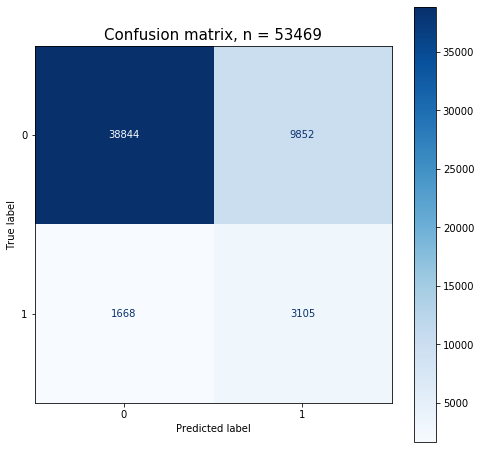

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(pipe_rf, # 분류 모델
                            X_val, y_val, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize = 15)
plt.show()

In [ ]:
y_pred = pipe_rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     48696
           1       0.24      0.65      0.35      4773

    accuracy                           0.78     53469
   macro avg       0.60      0.72      0.61     53469
weighted avg       0.89      0.78      0.82     53469



###5-3-3) 순열중요도와 특성 중요도 구하고 비교해보기

In [ ]:
# permuter 정의
permuter1 = PermutationImportance(
    pipe_rf.named_steps['rf'], # model
    scoring = 'f1', # metric
    n_iter = 5, # 다른 random seed를 사용하여 5번 반복
    random_state = 42
)

# permuter 계산은 preprocessing 된 X_val를 사용한다.
X_test_transformed_rf = pipe_rf.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업이다
permuter1.fit(X_test_transformed_rf, y_val);

In [ ]:
#cancer_dataset에서 feature_names 뽑아오기
feature_names = X_val.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter1, 
    top = None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names = feature_names # list 형식으로 넣어야 한다.
)

Weight,Feature
0.1205 ± 0.0023,AgeCategory
0.0783 ± 0.0058,GenHealth
0.0246 ± 0.0029,Sex
0.0113 ± 0.0038,Race
0.0055 ± 0.0012,DiffWalking
0.0045 ± 0.0014,Diabetic
0.0043 ± 0.0020,Smoking
0.0041 ± 0.0010,Stroke
0.0035 ± 0.0011,PhysicalHealth
0.0004 ± 0.0017,BMI


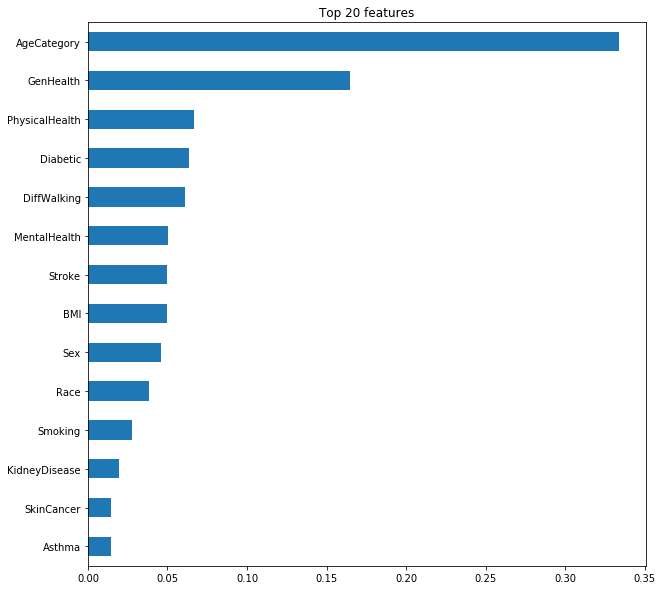

In [ ]:
# 특성 중요도
rf = pipe_rf.named_steps['rf']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

KidneyDisease, SkinCancer, Asthma column을 제거 하는 것이 모델을 더 가볍게 만들고 성능도 증가할 것 같다.

##5-4) XGBoost 모델

### 5-4-1) 모델 제작 및 RandomizedSearchCV를 이용해서 하이퍼 파라미터를 찾아보았다.

In [ ]:
%%time
# encoder, imputer를 preprocessing으로 묶었다. 후에 eli5 permutation 계산에 사용한다.
pipe3 = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(random_state = 2
                  , n_jobs = -1
                 )) 
])

#RandomizedSearchCV를 이용해서 각 하이퍼 파라미터에 대해서 학습을 할 범위를 정해준다.
dists2 = {
    'xgb__n_estimators': randint(50, 500), #몇개의 결정트리 모델을 만들어서 랜덤 포레스트 모델을 만들지 결정하는 하이퍼 파라미터이다.
    'xgb__max_depth': [5, 10, 15, 20, None], #몇번의 분기를 거쳐서 분류하는 결정트리 모델을 만들 것인지 결정하는 하이퍼 파라미터이다.
    'xgb__learning_rate': uniform(0, 1)
}

#randomized Search CV 진행조건을 설정해준다.
clf2 = RandomizedSearchCV(
    pipe3, #파이프라인으로 학습된 모델
    param_distributions = dists2, #하이퍼파라미터 튜닝 값으로 진행한다.
    n_iter = 50, # 반복 횟수
    cv = 3, # 교차검증 횟수 (==> n_iter * cv 의 숫자만큼 진행됨)
    scoring = 'f1',  # 오차 평가방법
    verbose = 1,# 훈련 중지여부를 화면에 출력 (1= progress bar/2= one line per epoch)
    n_jobs = -1, #컴퓨터의 모든 가용 자원을 이용해서 학습을 진행하라는 코드이다.
)

#randomized Search CV로 train data 학습 진행
clf2.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 10min 47s, sys: 8.48 s, total: 10min 56s
Wall time: 3h 4min 8s


 ### 5-4-2)최적의 하이퍼 파라미터 값을 이용한 모델 선택

In [ ]:
print('최적 하이퍼파라미터: ', clf2.best_params_)
print('accuracy: ', clf2.best_score_)

최적 하이퍼파라미터:  {'xgb__learning_rate': 0.9820279035306344, 'xgb__max_depth': 15, 'xgb__n_estimators': 431}
accuracy:  0.2298106362114105


In [ ]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf2.cv_results_).sort_values(by='rank_test_score').T

,46,8,39,34,43,18,9,3,24,30,...,35,1,44,31,29,38,23,32,41,40
mean_fit_time,361.063399,181.154231,201.236841,165.906459,230.290162,149.771869,120.675871,174.922541,261.208745,272.450847,...,21.948594,1.803123,1.819025,1.796076,1.804299,1.798862,1.815263,1.821108,1.798116,1.771521
std_fit_time,0.367182,0.630531,0.294089,0.597736,0.807897,0.290955,0.631102,3.273278,0.665127,0.788772,...,0.084015,0.020579,0.035441,0.019149,0.01697,0.001146,0.014064,0.010273,0.035275,0.000938
mean_score_time,18.379076,6.557217,7.356451,6.509555,8.152859,5.313495,3.099043,5.340612,12.326179,13.125525,...,0.685307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_score_time,0.171955,0.269087,0.248919,0.103247,0.098997,0.350937,0.039988,0.090899,0.138161,0.364932,...,0.008972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_xgb__learning_rate,0.982028,0.815279,0.993859,0.767715,0.508703,0.874988,0.93992,0.906677,0.383268,0.60305,...,0.121514,0.360063,0.666424,0.809224,0.733958,0.827759,0.071886,0.498614,0.932277,0.704305
param_xgb__max_depth,15,15,20,15,10,15,10,10,15,20,...,5,None,None,None,None,None,None,None,None,None
param_xgb__n_estimators,431,211,168,193,454,172,230,333,309,228,...,93,393,271,65,414,474,462,499,403,471
params,"{'xgb__learning_rate': 0.9820279035306344, 'xg...","{'xgb__learning_rate': 0.8152787364634094, 'xg...","{'xgb__learning_rate': 0.9938587414899142, 'xg...","{'xgb__learning_rate': 0.7677154446624452, 'xg...","{'xgb__learning_rate': 0.5087028860486205, 'xg...","{'xgb__learning_rate': 0.8749878020961609, 'xg...","{'xgb__learning_rate': 0.9399196049652531, 'xg...","{'xgb__learning_rate': 0.9066770704799644, 'xg...","{'xgb__learning_rate': 0.3832679858622139, 'xg...","{'xgb__learning_rate': 0.6030503231949079, 'xg...",...,"{'xgb__learning_rate': 0.12151350551162265, 'x...","{'xgb__learning_rate': 0.3600634311435219, 'xg...","{'xgb__learning_rate': 0.6664236902496503, 'xg...","{'xgb__learning_rate': 0.8092239480137454, 'xg...","{'xgb__learning_rate': 0.7339575476515318, 'xg...","{'xgb__learning_rate': 0.8277594207564107, 'xg...","{'xgb__learning_rate': 0.07188569251151777, 'x...","{'xgb__learning_rate': 0.498614313016402, 'xgb...","{'xgb__learning_rate': 0.9322768649423816, 'xg...","{'xgb__learning_rate': 0.7043045642411628, 'xg..."
split0_test_score,0.231707,0.229634,0.235163,0.228375,0.227036,0.229825,0.227268,0.226923,0.228571,0.226965,...,0.14323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
split1_test_score,0.220763,0.216575,0.217072,0.215791,0.218032,0.213198,0.213259,0.215326,0.21551,0.214471,...,0.140197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###5-4-3) 모델의 성능 확인

In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe_XGB = clf2.best_estimator_

In [ ]:
print('훈련 정확도: ', pipe_XGB.score(X_train, y_train))
print('검증 정확도: ', pipe_XGB.score(X_val, y_val))

훈련 정확도:  0.9619213271427436
검증 정확도:  0.8934709831865193


과적합이 심하게 되었음을 알 수 있다.

In [ ]:
y_proba = pipe_XGB.predict_proba(X_val)
# 사이킷런 결과 확인
sklearn_reslt = log_loss(y_val, y_proba)
print("sklearn_reslt", sklearn_reslt)

sklearn_reslt 0.4739107603721687


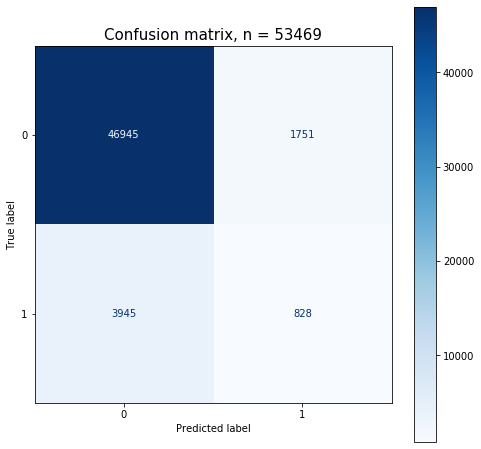

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(pipe_XGB, # 분류 모델
                            X_val, y_val, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize = 15)
plt.show()

In [ ]:
y_pred = pipe_XGB.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     48696
           1       0.32      0.17      0.23      4773

    accuracy                           0.89     53469
   macro avg       0.62      0.57      0.58     53469
weighted avg       0.87      0.89      0.88     53469



### 5-4-4) 순열중요도와 특성 중요도 구하고 비교해보기

In [ ]:
# permuter 정의
permuter2 = PermutationImportance(
    pipe_XGB.named_steps['xgb'], # model
    scoring = 'f1', # metric
    n_iter = 5, # 다른 random seed를 사용하여 5번 반복
    random_state = 42
)

# permuter 계산은 preprocessing 된 X_val를 사용한다.
X_test_transformed_XGB = pipe_XGB.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업이다
permuter2.fit(X_test_transformed_XGB, y_val);

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter2, 
    top = None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names = feature_names # list 형식으로 넣어야 한다.
)

Weight,Feature
0.0556 ± 0.0068,AgeCategory
0.0498 ± 0.0063,GenHealth
0.0282 ± 0.0034,Stroke
0.0203 ± 0.0035,Diabetic
0.0134 ± 0.0022,Sex
0.0113 ± 0.0022,KidneyDisease
0.0084 ± 0.0033,DiffWalking
0.0073 ± 0.0056,Smoking
0.0045 ± 0.0052,Race
0.0024 ± 0.0015,Asthma


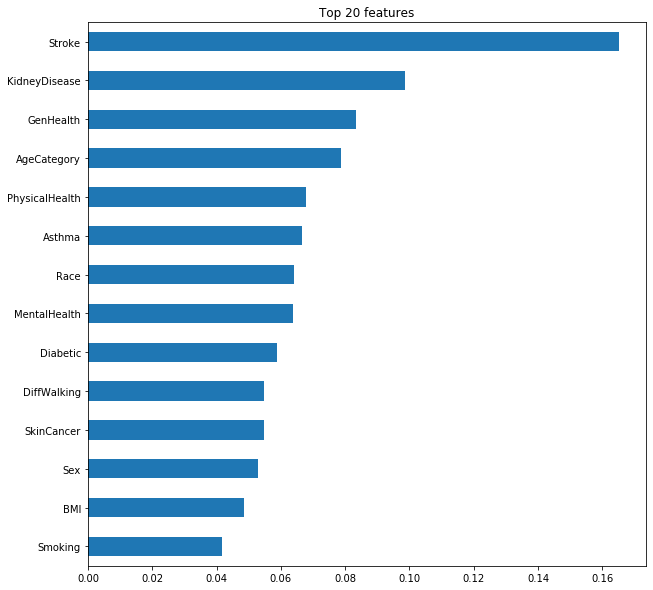

In [ ]:
# 특성 중요도
xgb = pipe_XGB.named_steps['xgb']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

###5-4-5) early_stopping_rounds를 이용해서 과적합이 줄어든 모델을 만들어 본다.

In [ ]:
#인코더를 거친 데이터를 만든다.
encoder = TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators = 1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth = 11,       
    learning_rate = 0.3, 
    scale_pos_weight = custom[1] / custom[0], # imbalance 데이터 일 경우 비율을 적용한니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 50 # 50 rounds 동안 스코어의 개선이 없으면 멈춤
         ) 

[0]	validation_0-error:0.263591	validation_1-error:0.2727
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.252687	validation_1-error:0.263124
[2]	validation_0-error:0.251995	validation_1-error:0.2629
[3]	validation_0-error:0.247437	validation_1-error:0.25815
[4]	validation_0-error:0.244313	validation_1-error:0.256018
[5]	validation_0-error:0.244318	validation_1-error:0.256897
[6]	validation_0-error:0.240568	validation_1-error:0.253867
[7]	validation_0-error:0.24054	validation_1-error:0.254316
[8]	validation_0-error:0.239619	validation_1-error:0.254054
[9]	validation_0-error:0.237519	validation_1-error:0.252296
[10]	validation_0-error:0.235972	validation_1-error:0.251884
[11]	validation_0-error:0.233746	validation_1-error:0.250313
[12]	validation_0-error:0.232414	validation_1-error:0.250145
[13]	validation_0-error:0.230338	validation_1-error:0.24835
[1

XGBClassifier(learning_rate=0.3, max_depth=11, n_estimators=1000, n_jobs=-1,
              scale_pos_weight=10.201057923955169)

###5-4-6) 모델의 성능 확인

In [ ]:
print('훈련 정확도: ', model.score(X_train_encoded, y_train))
print('검증 정확도: ', model.score(X_val_encoded, y_val))

print(classification_report(y_val, model.predict(X_val_encoded)))

훈련 정확도:  0.8860304947328554
검증 정확도:  0.8092913650900522
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     48696
           1       0.22      0.46      0.30      4773

    accuracy                           0.81     53469
   macro avg       0.58      0.65      0.59     53469
weighted avg       0.88      0.81      0.84     53469



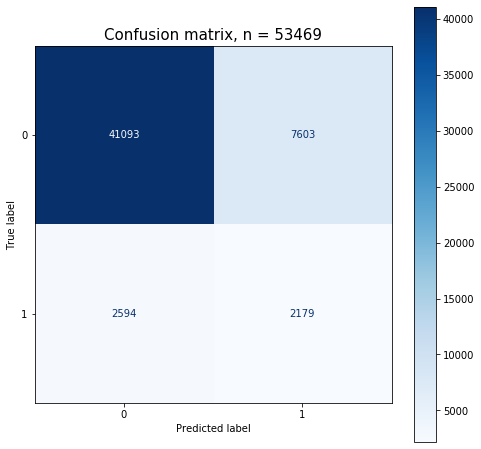

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(model, # 분류 모델
                            X_val_encoded, y_val, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize = 15)
plt.show()

In [ ]:
# permuter 정의
permuter3 = PermutationImportance(
    model, # model
    scoring = 'f1', # metric
    n_iter = 5, # 다른 random seed를 사용하여 5번 반복
    random_state = 42
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업이다
permuter3.fit(X_val_encoded, y_val);

In [ ]:
#cancer_dataset에서 feature_names 뽑아오기
feature_names = X_val.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter3, 
    top = None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names = feature_names # list 형식으로 넣어야 한다.
)

Weight,Feature
0.0960 ± 0.0038,AgeCategory
0.0529 ± 0.0046,GenHealth
0.0210 ± 0.0038,Sex
0.0131 ± 0.0024,Race
0.0112 ± 0.0044,MentalHealth
0.0101 ± 0.0021,Stroke
0.0079 ± 0.0043,Diabetic
0.0070 ± 0.0029,BMI
0.0039 ± 0.0023,DiffWalking
0.0032 ± 0.0046,Smoking


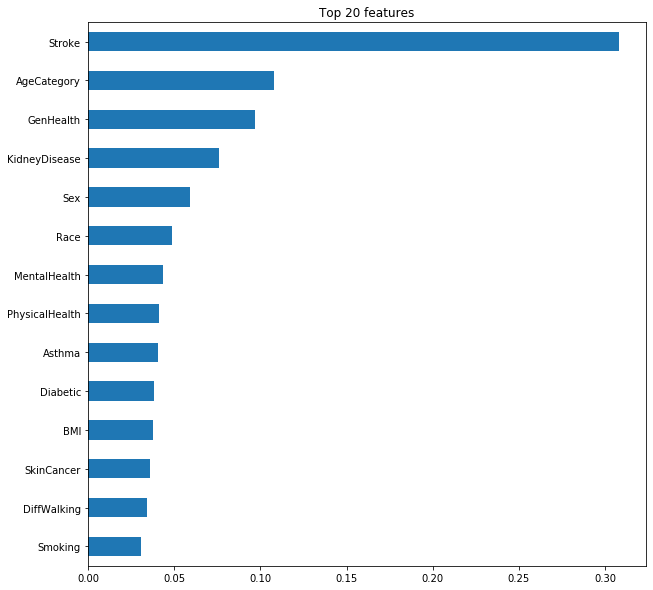

In [ ]:
# 특성 중요도
importances = pd.Series(model.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

##5-5)LightGBM 모델

###5-5-1) 모델 제작 및 RandomizedSearchCV를 이용해서 하이퍼 파라미터를 찾아보았다.

In [64]:
%%time
# encoder, imputer를 preprocessing으로 묶었다. 후에 eli5 permutation 계산에 사용한다.
pipe4 = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('lbgm', LGBMClassifier(random_state = 42,
                            n_jobs = -1,
                            objective = 'binary',
                            learning_rate = 0.1,
                            class_weight = {False:custom[0], True:custom[1]}
                            )) 
])

#RandomizedSearchCV를 이용해서 각 하이퍼 파라미터에 대해서 학습을 할 범위를 정해준다.
dists4 = {
    'lbgm__n_estimators': randint(50, 500), #몇개의 결정트리 모델을 만들어서 랜덤 포레스트 모델을 만들지 결정하는 하이퍼 파라미터이다.
    'lbgm__max_depth': [10, 11, 12, 13, 14, 15], #몇번의 분기를 거쳐서 분류하는 결정트리 모델을 만들 것인지 결정하는 하이퍼 파라미터이다.
    'lbgm__num_leaves ': randint(50, 100), #전체 Tree의 leave 수 
}

#randomized Search CV 진행조건을 설정해준다.
clf4 = RandomizedSearchCV(
    pipe4, #파이프라인으로 학습된 모델
    param_distributions = dists4, #하이퍼파라미터 튜닝 값으로 진행한다.
    n_iter = 50, # 반복 횟수
    cv = 3, # 교차검증 횟수 (==> n_iter * cv 의 숫자만큼 진행됨)
    scoring = 'f1',  # 오차 평가방법
    verbose = 1,# 훈련 중지여부를 화면에 출력 (1= progress bar/2= one line per epoch)
    n_jobs = -1, #컴퓨터의 모든 가용 자원을 이용해서 학습을 진행하라는 코드이다.
)

#randomized Search CV로 train data 학습 진행
clf4.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 40.5 s, sys: 1.36 s, total: 41.8 s
Wall time: 14min 59s


###5-5-2) 최적의 하이퍼 파라미터 값을 이용한 모델 선택

In [65]:
print('최적 하이퍼파라미터: ', clf4.best_params_)
print('accuracy: ', clf4.best_score_)

최적 하이퍼파라미터:  {'lbgm__max_depth': 15, 'lbgm__n_estimators': 491, 'lbgm__num_leaves ': 82}
accuracy:  0.3505450118573948


In [66]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf4.cv_results_).sort_values(by='rank_test_score').T

,21,12,43,45,11,47,4,23,0,3,...,20,27,37,32,28,1,41,5,33,19
mean_fit_time,14.303618,14.599845,13.067758,12.641727,14.090541,12.698813,11.634273,12.479799,15.535578,11.364059,...,8.639222,7.10459,6.609842,6.075365,5.638533,6.126137,5.381875,5.05611,4.143792,4.278974
std_fit_time,0.197067,0.213425,0.147911,0.075887,0.086078,0.091998,0.143935,0.180023,2.166715,0.05536,...,0.185412,0.082871,0.060063,0.017593,0.063969,0.035461,0.167751,0.025086,0.025973,0.087468
mean_score_time,2.32348,2.35547,2.12588,2.072718,2.241,2.20665,1.847767,2.076676,2.315618,1.795927,...,1.362544,1.159709,1.062213,1.011952,0.876516,0.935628,0.861742,0.776032,0.638809,0.632695
std_score_time,0.079422,0.045186,0.054298,0.050512,0.034639,0.106931,0.026232,0.065256,0.265125,0.078822,...,0.012394,0.019423,0.018465,0.069497,0.018736,0.021836,0.06061,0.020539,0.019422,0.018765
param_lbgm__max_depth,15,12,13,12,12,12,15,15,12,15,...,10,15,10,10,13,10,14,11,12,12
param_lbgm__n_estimators,491,498,454,434,487,436,401,413,439,388,...,234,176,153,132,111,140,102,91,53,51
param_lbgm__num_leaves,82,91,74,69,85,70,75,57,90,59,...,93,78,62,57,64,84,69,66,86,76
params,"{'lbgm__max_depth': 15, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 13, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 15, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 15, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 15, 'lbgm__n_estimators': ...",...,"{'lbgm__max_depth': 10, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 15, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 10, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 10, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 13, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 10, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 14, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 11, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ...","{'lbgm__max_depth': 12, 'lbgm__n_estimators': ..."
split0_test_score,0.348501,0.350521,0.348994,0.350336,0.350167,0.350056,0.348114,0.348136,0.349924,0.348267,...,0.346757,0.346746,0.345482,0.345336,0.345572,0.345073,0.345682,0.345318,0.343112,0.342888
split1_test_score,0.352812,0.350839,0.352102,0.350835,0.350923,0.350827,0.351672,0.352026,0.350783,0.351637,...,0.349101,0.349167,0.348897,0.348492,0.348569,0.348562,0.348366,0.347829,0.345659,0.345572


###5-5-3)  모델의 성능 확인

In [67]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe_LGBM = clf4.best_estimator_

In [68]:
print('훈련 정확도: ', pipe_LGBM.score(X_train, y_train))
print('검증 정확도: ', pipe_LGBM.score(X_val, y_val))

훈련 정확도:  0.7535125985982335
검증 정확도:  0.7431221829471283


In [69]:
y_proba = pipe_LGBM.predict_proba(X_val)
# 사이킷런 결과 확인
sklearn_reslt = log_loss(y_val, y_proba)
print("sklearn_reslt", sklearn_reslt)

sklearn_reslt 0.47501918689307643


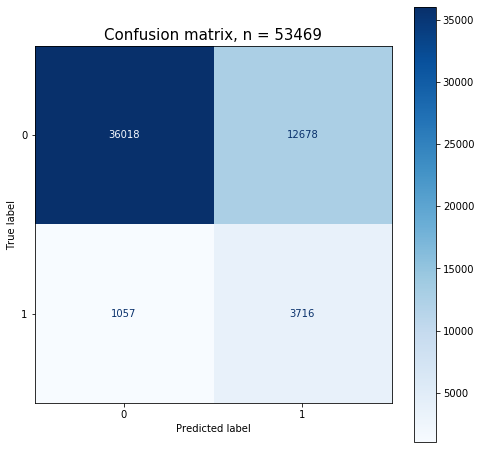

In [70]:
fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(pipe_LGBM, # 분류 모델
                            X_val, y_val, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize = 15)
plt.show()

In [71]:
y_pred = pipe_LGBM.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     48696
           1       0.23      0.78      0.35      4773

    accuracy                           0.74     53469
   macro avg       0.60      0.76      0.60     53469
weighted avg       0.91      0.74      0.80     53469



###5-5-4)  순열중요도와 특성 중요도 구하고 비교해보기

In [73]:
# permuter 정의
permuter4 = PermutationImportance(
    pipe_LGBM.named_steps['lbgm'], # model
    scoring = 'f1', # metric
    n_iter = 5, # 다른 random seed를 사용하여 5번 반복
    random_state = 42
)

# permuter 계산은 preprocessing 된 X_val를 사용한다.
X_test_transformed_lbgm = pipe_LGBM.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업이다
permuter4.fit(X_test_transformed_lbgm, y_val);

In [74]:
#cancer_dataset에서 feature_names 뽑아오기
feature_names = X_val.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter4, 
    top = None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names = feature_names # list 형식으로 넣어야 한다.
)

Weight,Feature
0.0911 ± 0.0024,AgeCategory
0.0326 ± 0.0010,GenHealth
0.0178 ± 0.0037,Sex
0.0158 ± 0.0017,Stroke
0.0032 ± 0.0009,Diabetic
0.0031 ± 0.0019,Race
0.0030 ± 0.0012,Smoking
0.0021 ± 0.0014,PhysicalHealth
0.0015 ± 0.0009,KidneyDisease
0.0009 ± 0.0003,Asthma


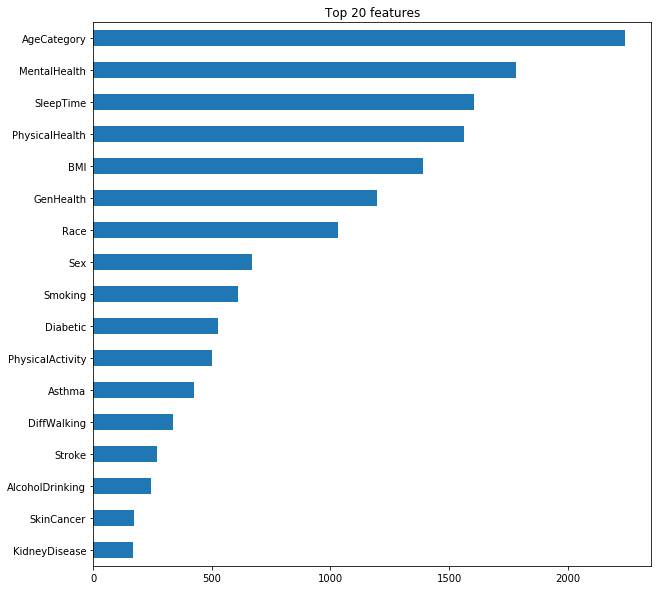

In [75]:
# 특성 중요도
lbgm = pipe_LGBM.named_steps['lbgm']
importances = pd.Series(lbgm.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# 6. 업샘플링 

##6-1)업샘플링을 이용해서 심장병인 데이터(1)와 심장병이 아닌 데이터(0)의 비율을 맞춰주겠다.
* Random Over-Sampling을 이용할 것이다.

In [ ]:
smote = RandomOverSampler(sampling_strategy=1)
X_smote, y_smote = smote.fit_resample(X,y)